In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nfunswnb15v2/NF-UNSW-NB15-V2.parquet
/kaggle/input/nfunswnb15v2/NetFlow v2 Features.csv


In [2]:
from fastcore.basics import *
from fastcore.parallel import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score
from os import cpu_count
from math import floor
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
import shap
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
shap.initjs()

In [3]:
data=pd.read_parquet("/kaggle/input/nfunswnb15v2/NF-UNSW-NB15-V2.parquet")

## very very Basic EDA

In [4]:
data.dtypes

L4_SRC_PORT                      int32
L4_DST_PORT                      int32
PROTOCOL                         int16
L7_PROTO                       float32
IN_BYTES                         int32
IN_PKTS                          int16
OUT_BYTES                        int32
OUT_PKTS                         int16
TCP_FLAGS                         int8
CLIENT_TCP_FLAGS                  int8
SERVER_TCP_FLAGS                  int8
FLOW_DURATION_MILLISECONDS       int32
DURATION_IN                      int16
DURATION_OUT                     int16
MIN_TTL                          int16
MAX_TTL                          int16
LONGEST_FLOW_PKT                 int16
SHORTEST_FLOW_PKT                int16
MIN_IP_PKT_LEN                   int16
MAX_IP_PKT_LEN                   int16
SRC_TO_DST_SECOND_BYTES        float32
DST_TO_SRC_SECOND_BYTES        float32
RETRANSMITTED_IN_BYTES           int32
RETRANSMITTED_IN_PKTS            int16
RETRANSMITTED_OUT_BYTES          int32
RETRANSMITTED_OUT_PKTS   

In [5]:
data.Label.value_counts()

0    1911666
1      75079
Name: Label, dtype: int64

In [6]:
data.Attack.value_counts()

Benign            1911666
Exploits            29905
Fuzzers             20645
Reconnaissance      11171
Generic              5992
DoS                  4172
Shellcode            1427
Backdoor              833
Analysis              770
Worms                 164
Name: Attack, dtype: int64

In [7]:
data=data.drop(columns=['L4_SRC_PORT', 'L4_DST_PORT']) #dropping metadata

## Finding contaminant features using XAI (SHAP)
goal: 
- try to find the contaminant features that have blanked predictive power across all attack classes

method:
* look for shap values per feature that are consistantly high or low among all attack classes.
   
how:
```
possible_contaminants =[]
    while models can achive high accuracy{
    
        * Train a binary classification model (e.g., xgboost) on different attack classes and benign class
        * For each model, calculate shappley values on test set
        * For each model, use np.abs(shap_values).mean(0) to compute the mean absolute SHAP value for each feature across all samples. 
          This will give you a measure of how much each feature contributes to the model output on average across all samples (the importance).
          
        * normalize importances across for each attack class sum of feature importances equals 1
        * for each feature, calculate variance of importance for each attack class
        * for each feature, calculate average importance across all attack classes
        * score of a feature is the weighted sum of the importance and variance
        
        * feature F is feature with the highest score
        * possible_contaminants.append(F)
        * drop F from dataset
    }
```

In [8]:
training_set = data.sample(frac=0.3, replace=False,random_state=42)
# 1%train, 99% test
testing_set = data.drop(index=training_set.index)

In [9]:
training_set.Attack.value_counts()

Benign            573514
Exploits            8929
Fuzzers             6196
Reconnaissance      3356
Generic             1839
DoS                 1232
Shellcode            448
Backdoor             241
Analysis             225
Worms                 44
Name: Attack, dtype: int64

In [10]:
testing_set=testing_set[testing_set.Attack!="Worms"]

In [11]:
training_set=training_set[training_set.Attack!="Worms"]
attacks=training_set.Attack.unique()
attacks

array(['Benign', 'Fuzzers', 'Reconnaissance', 'Exploits', 'DoS',
       'Generic', 'Analysis', 'Shellcode', 'Backdoor'], dtype=object)

### Correlated features

In [12]:
corr = training_set.corr()
corr_features={corr.columns[i] : corr.columns[(corr>0.9).iloc[i]].values.tolist() for i in range(0,corr.shape[0])}
corr_list=[]
for key,value in corr_features.items():
#     check if we already have this set
    have_set=False
    for set_s in corr_list:
        if key in set_s:
#             we have found a set
            have_set=True
            break
    if have_set==False and len(value)>1:
        corr_list.append(value)

In [13]:
corr_list

[['IN_BYTES', 'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS'],
 ['OUT_BYTES',
  'OUT_PKTS',
  'RETRANSMITTED_OUT_BYTES',
  'RETRANSMITTED_OUT_PKTS',
  'NUM_PKTS_1024_TO_1514_BYTES'],
 ['TCP_FLAGS', 'CLIENT_TCP_FLAGS', 'SERVER_TCP_FLAGS'],
 ['MIN_TTL', 'MAX_TTL'],
 ['LONGEST_FLOW_PKT', 'MAX_IP_PKT_LEN'],
 ['ICMP_TYPE', 'ICMP_IPV4_TYPE']]

In [14]:
#dropping all but one feature per correlation group
for i in range(len(corr_list)):
    training_set.drop(columns=corr_list[i][1:],inplace=True)
    testing_set.drop(columns=corr_list[i][1:],inplace=True)

### split into dataframes per attack class

In [15]:
grouped = training_set.groupby(training_set.Attack)
dfs={cat:grouped.get_group(cat) for cat in attacks[1:]}
dfs[attacks[0]]=grouped.get_group(attacks[0]) #don't subsample normal attacks
#dfs key=attack_cat, value is dataframe 

In [16]:
for atk_type in attacks[1:]:
    normals_to_sample = dfs[atk_type].shape[0]
#     print(normals_to_sample)
    normals_sample = dfs['Benign'].sample(normals_to_sample)
#     dfs['Normal'] = dfs['Normal'].drop(index=normals_sample.index)#don't resample
    dfs[atk_type] = pd.concat(objs=[dfs[atk_type], normals_sample])
    print(dfs[atk_type].shape[0], normals_sample.shape[0], dfs['Benign'].shape[0])

12392 6196 573514
6712 3356 573514
17858 8929 573514
2464 1232 573514
3678 1839 573514
450 225 573514
896 448 573514
482 241 573514


In [17]:
testing_dfs = {}
grouped = testing_set.groupby(testing_set.Attack)
testing_dfs={cat:grouped.get_group(cat) for cat in attacks[1:]}
testing_dfs[attacks[0]]=grouped.get_group(attacks[0]) #don't subsample normal attacks
#testing_dfs key=attack_cat, value is dataframe 

In [18]:
for atk_type in attacks[1:]:
    normals_to_sample = testing_dfs[atk_type].shape[0] 
    normals_sample = testing_dfs['Benign'].sample(normals_to_sample)
#     testing_dfs['Normal'] = testing_dfs['Normal'].drop(index=normals_sample.index)#don't resample
    testing_dfs[atk_type] = pd.concat(objs=[testing_dfs[atk_type], normals_sample])
    print(testing_dfs[atk_type].shape[0], normals_sample.shape[0], testing_dfs['Benign'].shape[0])

28898 14449 1338152
15630 7815 1338152
41952 20976 1338152
5880 2940 1338152
8306 4153 1338152
1090 545 1338152
1958 979 1338152
1184 592 1338152


In [19]:
print(f"TRAINING SETS")
for k,v in dfs.items():
    v.drop(columns=['Attack'], inplace=True)   
    print(k, v.shape)
    print(v['Label'].value_counts())

TRAINING SETS
Fuzzers (12392, 29)
1    6196
0    6196
Name: Label, dtype: int64
Reconnaissance (6712, 29)
1    3356
0    3356
Name: Label, dtype: int64
Exploits (17858, 29)
1    8929
0    8929
Name: Label, dtype: int64
DoS (2464, 29)
1    1232
0    1232
Name: Label, dtype: int64
Generic (3678, 29)
1    1839
0    1839
Name: Label, dtype: int64
Analysis (450, 29)
1    225
0    225
Name: Label, dtype: int64
Shellcode (896, 29)
1    448
0    448
Name: Label, dtype: int64
Backdoor (482, 29)
1    241
0    241
Name: Label, dtype: int64
Benign (573514, 29)
0    573514
Name: Label, dtype: int64


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [20]:
print("TESTING SETS")
for k,v in testing_dfs.items():
    v.drop(columns=['Attack'], inplace=True)   
    print(k, v.shape)
    print(v['Label'].value_counts())

TESTING SETS
Fuzzers (28898, 29)
1    14449
0    14449
Name: Label, dtype: int64
Reconnaissance (15630, 29)
1    7815
0    7815
Name: Label, dtype: int64
Exploits (41952, 29)
1    20976
0    20976
Name: Label, dtype: int64
DoS (5880, 29)
1    2940
0    2940
Name: Label, dtype: int64
Generic (8306, 29)
1    4153
0    4153
Name: Label, dtype: int64
Analysis (1090, 29)
1    545
0    545
Name: Label, dtype: int64
Shellcode (1958, 29)
1    979
0    979
Name: Label, dtype: int64
Backdoor (1184, 29)
1    592
0    592
Name: Label, dtype: int64
Benign (1338152, 29)
0    1338152
Name: Label, dtype: int64


In [21]:
training_dfs=dfs

ITERATION: 0
['Fuzzers', 0.996, 0.001, 0.995, 0.001, 0.998, 0.0]
['Reconnaissance', 0.998, 0.0, 0.997, 0.001, 0.998, 0.0]
['Exploits', 0.997, 0.0, 0.994, 0.0, 1.0, 0.0]
['DoS', 0.995, 0.001, 0.991, 0.001, 0.999, 0.001]
['Generic', 0.997, 0.0, 0.995, 0.0, 0.999, 0.001]
['Analysis', 0.993, 0.0, 0.986, 0.001, 1.0, 0.001]
['Shellcode', 0.995, 0.002, 0.991, 0.004, 0.999, 0.001]
['Backdoor', 0.991, 0.006, 0.992, 0.002, 0.99, 0.011]
top features ['MIN_TTL', 'MIN_IP_PKT_LEN', 'SHORTEST_FLOW_PKT']
top importances [0.25879897 0.19937985 0.09429943]
 feature to be dropped: MIN_TTL
 correlated features: [['MIN_TTL', 'MAX_TTL']]


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 1
['Fuzzers', 0.996, 0.0, 0.994, 0.0, 0.998, 0.0]
['Reconnaissance', 0.998, 0.0, 0.997, 0.0, 0.998, 0.001]
['Exploits', 0.996, 0.0, 0.993, 0.0, 0.999, 0.0]
['DoS', 0.994, 0.0, 0.991, 0.001, 0.997, 0.001]
['Generic', 0.997, 0.001, 0.995, 0.001, 0.998, 0.001]
['Analysis', 0.99, 0.004, 0.987, 0.001, 0.992, 0.008]
['Shellcode', 0.994, 0.001, 0.988, 0.002, 0.999, 0.001]
['Backdoor', 0.991, 0.007, 0.991, 0.001, 0.991, 0.014]
top features ['MIN_IP_PKT_LEN', 'SHORTEST_FLOW_PKT', 'TCP_FLAGS']
top importances [0.29747237 0.10165143 0.08912571]
 feature to be dropped: MIN_IP_PKT_LEN
 correlated features: []


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 2
['Fuzzers', 0.996, 0.0, 0.995, 0.0, 0.998, 0.0]
['Reconnaissance', 0.997, 0.0, 0.997, 0.0, 0.997, 0.001]
['Exploits', 0.996, 0.0, 0.993, 0.0, 0.999, 0.0]
['DoS', 0.994, 0.001, 0.991, 0.001, 0.997, 0.001]
['Generic', 0.997, 0.0, 0.994, 0.001, 0.999, 0.001]
['Analysis', 0.989, 0.004, 0.987, 0.001, 0.991, 0.008]
['Shellcode', 0.995, 0.001, 0.99, 0.002, 1.0, 0.0]
['Backdoor', 0.99, 0.003, 0.992, 0.001, 0.988, 0.006]
top features ['SHORTEST_FLOW_PKT', 'DST_TO_SRC_SECOND_BYTES', 'OUT_BYTES']
top importances [0.17054057 0.11430538 0.10692835]
 feature to be dropped: SHORTEST_FLOW_PKT
 correlated features: []


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 3
['Fuzzers', 0.996, 0.0, 0.994, 0.001, 0.998, 0.0]
['Reconnaissance', 0.997, 0.0, 0.997, 0.001, 0.997, 0.0]
['Exploits', 0.996, 0.0, 0.993, 0.0, 1.0, 0.0]
['DoS', 0.993, 0.001, 0.99, 0.002, 0.996, 0.002]
['Generic', 0.996, 0.001, 0.994, 0.001, 0.998, 0.001]
['Analysis', 0.989, 0.003, 0.989, 0.002, 0.989, 0.006]
['Shellcode', 0.995, 0.001, 0.99, 0.001, 0.999, 0.001]
['Backdoor', 0.983, 0.003, 0.991, 0.001, 0.975, 0.006]
top features ['TCP_FLAGS', 'TCP_WIN_MAX_OUT', 'DST_TO_SRC_SECOND_BYTES']
top importances [0.14452616 0.12520356 0.11036467]
 feature to be dropped: TCP_FLAGS
 correlated features: [['TCP_FLAGS', 'CLIENT_TCP_FLAGS', 'SERVER_TCP_FLAGS']]


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 4
['Fuzzers', 0.996, 0.0, 0.993, 0.001, 0.998, 0.0]
['Reconnaissance', 0.997, 0.0, 0.997, 0.0, 0.997, 0.001]
['Exploits', 0.996, 0.0, 0.993, 0.0, 0.999, 0.0]
['DoS', 0.993, 0.001, 0.99, 0.002, 0.997, 0.002]
['Generic', 0.997, 0.001, 0.994, 0.001, 0.999, 0.001]
['Analysis', 0.986, 0.004, 0.982, 0.009, 0.99, 0.007]
['Shellcode', 0.995, 0.001, 0.991, 0.002, 0.999, 0.001]
['Backdoor', 0.981, 0.004, 0.991, 0.003, 0.97, 0.006]
top features ['TCP_WIN_MAX_OUT', 'DST_TO_SRC_SECOND_BYTES', 'OUT_BYTES']
top importances [0.15315806 0.13104404 0.12044296]
 feature to be dropped: TCP_WIN_MAX_OUT
 correlated features: []


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 5
['Fuzzers', 0.995, 0.0, 0.993, 0.0, 0.998, 0.0]
['Reconnaissance', 0.997, 0.0, 0.997, 0.0, 0.997, 0.0]
['Exploits', 0.996, 0.0, 0.992, 0.001, 0.999, 0.0]
['DoS', 0.993, 0.001, 0.989, 0.002, 0.997, 0.001]
['Generic', 0.995, 0.001, 0.994, 0.001, 0.997, 0.002]
['Analysis', 0.985, 0.002, 0.988, 0.002, 0.983, 0.004]
['Shellcode', 0.995, 0.002, 0.991, 0.003, 0.999, 0.001]
['Backdoor', 0.977, 0.005, 0.99, 0.003, 0.964, 0.008]
top features ['TCP_WIN_MAX_IN', 'DST_TO_SRC_SECOND_BYTES', 'OUT_BYTES']
top importances [0.15775071 0.15133917 0.12319918]
 feature to be dropped: TCP_WIN_MAX_IN
 correlated features: []


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 6
['Fuzzers', 0.994, 0.0, 0.991, 0.001, 0.997, 0.001]
['Reconnaissance', 0.996, 0.001, 0.997, 0.001, 0.996, 0.001]
['Exploits', 0.992, 0.0, 0.988, 0.0, 0.998, 0.0]
['DoS', 0.983, 0.004, 0.981, 0.002, 0.985, 0.006]
['Generic', 0.984, 0.001, 0.987, 0.002, 0.982, 0.003]
['Analysis', 0.982, 0.004, 0.98, 0.008, 0.983, 0.01]
['Shellcode', 0.995, 0.001, 0.991, 0.002, 0.999, 0.001]
['Backdoor', 0.967, 0.003, 0.982, 0.005, 0.952, 0.009]
top features ['DST_TO_SRC_SECOND_BYTES', 'OUT_BYTES', 'DST_TO_SRC_AVG_THROUGHPUT']
top importances [0.15140242 0.13875198 0.12805173]
 feature to be dropped: DST_TO_SRC_SECOND_BYTES
 correlated features: []


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 7
['Fuzzers', 0.993, 0.0, 0.99, 0.0, 0.997, 0.0]
['Reconnaissance', 0.996, 0.001, 0.996, 0.001, 0.997, 0.0]
['Exploits', 0.992, 0.0, 0.987, 0.001, 0.998, 0.0]
['DoS', 0.984, 0.001, 0.981, 0.001, 0.988, 0.002]
['Generic', 0.984, 0.003, 0.988, 0.001, 0.98, 0.005]
['Analysis', 0.982, 0.006, 0.978, 0.01, 0.986, 0.005]
['Shellcode', 0.995, 0.001, 0.992, 0.002, 0.998, 0.0]
['Backdoor', 0.968, 0.007, 0.98, 0.007, 0.956, 0.013]
top features ['OUT_BYTES', 'DST_TO_SRC_AVG_THROUGHPUT', 'NUM_PKTS_UP_TO_128_BYTES']
top importances [0.19348079 0.14621712 0.12915558]
 feature to be dropped: OUT_BYTES
 correlated features: [['OUT_BYTES', 'OUT_PKTS', 'RETRANSMITTED_OUT_BYTES', 'RETRANSMITTED_OUT_PKTS', 'NUM_PKTS_1024_TO_1514_BYTES']]


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 8
['Fuzzers', 0.993, 0.001, 0.99, 0.001, 0.997, 0.001]
['Reconnaissance', 0.996, 0.001, 0.996, 0.001, 0.996, 0.0]
['Exploits', 0.992, 0.0, 0.987, 0.001, 0.997, 0.0]
['DoS', 0.983, 0.001, 0.978, 0.002, 0.987, 0.002]
['Generic', 0.984, 0.001, 0.986, 0.001, 0.982, 0.003]
['Analysis', 0.984, 0.004, 0.981, 0.007, 0.987, 0.006]
['Shellcode', 0.995, 0.001, 0.991, 0.001, 0.999, 0.001]
['Backdoor', 0.969, 0.002, 0.981, 0.005, 0.957, 0.004]
top features ['DST_TO_SRC_AVG_THROUGHPUT', 'NUM_PKTS_UP_TO_128_BYTES', 'IN_PKTS']
top importances [0.20872832 0.15875499 0.11429272]
 feature to be dropped: DST_TO_SRC_AVG_THROUGHPUT
 correlated features: []


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 9
['Fuzzers', 0.993, 0.0, 0.99, 0.001, 0.997, 0.0]
['Reconnaissance', 0.995, 0.001, 0.995, 0.002, 0.996, 0.0]
['Exploits', 0.992, 0.0, 0.988, 0.001, 0.997, 0.0]
['DoS', 0.981, 0.002, 0.979, 0.002, 0.983, 0.004]
['Generic', 0.984, 0.002, 0.987, 0.001, 0.981, 0.003]
['Analysis', 0.972, 0.008, 0.985, 0.008, 0.959, 0.01]
['Shellcode', 0.996, 0.001, 0.993, 0.003, 0.998, 0.002]
['Backdoor', 0.964, 0.006, 0.981, 0.011, 0.947, 0.005]
top features ['NUM_PKTS_UP_TO_128_BYTES', 'IN_PKTS', 'LONGEST_FLOW_PKT']
top importances [0.22396321 0.13866839 0.10946023]
 feature to be dropped: NUM_PKTS_UP_TO_128_BYTES
 correlated features: []


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 10
['Fuzzers', 0.993, 0.0, 0.989, 0.0, 0.997, 0.001]
['Reconnaissance', 0.996, 0.0, 0.996, 0.001, 0.995, 0.001]
['Exploits', 0.992, 0.0, 0.987, 0.001, 0.997, 0.001]
['DoS', 0.979, 0.002, 0.978, 0.003, 0.98, 0.004]
['Generic', 0.983, 0.002, 0.985, 0.002, 0.98, 0.004]
['Analysis', 0.981, 0.003, 0.991, 0.001, 0.97, 0.007]
['Shellcode', 0.996, 0.001, 0.994, 0.001, 0.998, 0.002]
['Backdoor', 0.963, 0.008, 0.976, 0.014, 0.949, 0.009]
top features ['IN_PKTS', 'LONGEST_FLOW_PKT', 'SRC_TO_DST_SECOND_BYTES']
top importances [0.22137891 0.12512332 0.11496904]
 feature to be dropped: IN_PKTS
 correlated features: []


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 11
['Fuzzers', 0.993, 0.0, 0.99, 0.001, 0.996, 0.0]
['Reconnaissance', 0.995, 0.001, 0.996, 0.001, 0.994, 0.001]
['Exploits', 0.991, 0.001, 0.986, 0.001, 0.996, 0.001]
['DoS', 0.976, 0.003, 0.971, 0.003, 0.98, 0.004]
['Generic', 0.979, 0.002, 0.981, 0.001, 0.977, 0.003]
['Analysis', 0.976, 0.003, 0.987, 0.003, 0.965, 0.004]
['Shellcode', 0.995, 0.001, 0.99, 0.001, 0.999, 0.001]
['Backdoor', 0.966, 0.004, 0.982, 0.008, 0.949, 0.008]
top features ['LONGEST_FLOW_PKT', 'SRC_TO_DST_SECOND_BYTES', 'IN_BYTES']
top importances [0.16682849 0.15878381 0.11363704]
 feature to be dropped: LONGEST_FLOW_PKT
 correlated features: [['LONGEST_FLOW_PKT', 'MAX_IP_PKT_LEN']]


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 12
['Fuzzers', 0.991, 0.001, 0.987, 0.001, 0.994, 0.001]
['Reconnaissance', 0.994, 0.001, 0.994, 0.001, 0.994, 0.001]
['Exploits', 0.988, 0.001, 0.983, 0.001, 0.992, 0.001]
['DoS', 0.97, 0.001, 0.971, 0.001, 0.969, 0.002]
['Generic', 0.976, 0.002, 0.98, 0.001, 0.972, 0.004]
['Analysis', 0.976, 0.005, 0.985, 0.007, 0.966, 0.006]
['Shellcode', 0.994, 0.001, 0.99, 0.002, 0.998, 0.001]
['Backdoor', 0.958, 0.003, 0.972, 0.005, 0.945, 0.005]
top features ['SRC_TO_DST_SECOND_BYTES', 'IN_BYTES', 'SRC_TO_DST_AVG_THROUGHPUT']
top importances [0.18410802 0.14217055 0.13038167]
 feature to be dropped: SRC_TO_DST_SECOND_BYTES
 correlated features: []


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 13
['Fuzzers', 0.99, 0.0, 0.987, 0.001, 0.993, 0.001]
['Reconnaissance', 0.994, 0.0, 0.993, 0.001, 0.994, 0.001]
['Exploits', 0.987, 0.001, 0.982, 0.001, 0.992, 0.001]
['DoS', 0.967, 0.002, 0.968, 0.002, 0.966, 0.004]
['Generic', 0.97, 0.002, 0.979, 0.002, 0.962, 0.006]
['Analysis', 0.973, 0.004, 0.979, 0.003, 0.966, 0.007]
['Shellcode', 0.994, 0.001, 0.989, 0.003, 0.999, 0.001]
['Backdoor', 0.951, 0.002, 0.967, 0.006, 0.935, 0.008]
top features ['IN_BYTES', 'SRC_TO_DST_AVG_THROUGHPUT', 'L7_PROTO']
top importances [0.2059217  0.17369675 0.11643766]
 feature to be dropped: IN_BYTES
 correlated features: [['IN_BYTES', 'RETRANSMITTED_IN_BYTES', 'RETRANSMITTED_IN_PKTS']]


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 14
['Fuzzers', 0.989, 0.001, 0.987, 0.0, 0.992, 0.001]
['Reconnaissance', 0.994, 0.001, 0.994, 0.001, 0.994, 0.001]
['Exploits', 0.985, 0.001, 0.98, 0.001, 0.99, 0.001]
['DoS', 0.964, 0.003, 0.961, 0.003, 0.966, 0.005]
['Generic', 0.969, 0.003, 0.979, 0.003, 0.958, 0.005]
['Analysis', 0.979, 0.005, 0.984, 0.011, 0.973, 0.005]
['Shellcode', 0.993, 0.002, 0.991, 0.003, 0.996, 0.002]
['Backdoor', 0.947, 0.008, 0.957, 0.008, 0.935, 0.011]
top features ['SRC_TO_DST_AVG_THROUGHPUT', 'L7_PROTO', 'ICMP_TYPE']
top importances [0.25546807 0.14215846 0.13115798]
 feature to be dropped: SRC_TO_DST_AVG_THROUGHPUT
 correlated features: []


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 15
['Fuzzers', 0.978, 0.0, 0.971, 0.001, 0.986, 0.001]
['Reconnaissance', 0.996, 0.001, 0.996, 0.001, 0.995, 0.002]
['Exploits', 0.968, 0.002, 0.963, 0.001, 0.973, 0.003]
['DoS', 0.939, 0.006, 0.969, 0.003, 0.907, 0.012]
['Generic', 0.963, 0.003, 0.981, 0.002, 0.945, 0.006]
['Analysis', 0.981, 0.005, 0.995, 0.006, 0.966, 0.008]
['Shellcode', 0.967, 0.005, 0.944, 0.009, 0.993, 0.003]
['Backdoor', 0.943, 0.006, 0.966, 0.006, 0.918, 0.014]
top features ['ICMP_TYPE', 'L7_PROTO', 'PROTOCOL']
top importances [0.20289273 0.17376849 0.17414148]
 feature to be dropped: ICMP_TYPE
 correlated features: [['ICMP_TYPE', 'ICMP_IPV4_TYPE']]


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 16
['Fuzzers', 0.858, 0.001, 0.81, 0.003, 0.934, 0.008]
['Reconnaissance', 0.928, 0.0, 0.877, 0.001, 0.997, 0.0]
['Exploits', 0.899, 0.001, 0.904, 0.015, 0.893, 0.016]
['DoS', 0.886, 0.003, 0.936, 0.021, 0.83, 0.02]
['Generic', 0.915, 0.002, 0.964, 0.011, 0.861, 0.007]
['Analysis', 0.976, 0.002, 0.982, 0.003, 0.97, 0.004]
['Shellcode', 0.891, 0.0, 0.825, 0.0, 0.992, 0.0]
['Backdoor', 0.889, 0.008, 0.876, 0.033, 0.911, 0.056]
top features ['L7_PROTO', 'PROTOCOL', 'NUM_PKTS_256_TO_512_BYTES']
top importances [0.22743357 0.19030606 0.13356233]
 feature to be dropped: L7_PROTO
 correlated features: []


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 17
['Fuzzers', 0.832, 0.0, 0.795, 0.001, 0.896, 0.001]
['Reconnaissance', 0.901, 0.0, 0.838, 0.0, 0.996, 0.001]
['Exploits', 0.828, 0.003, 0.834, 0.013, 0.82, 0.023]
['DoS', 0.81, 0.003, 0.838, 0.003, 0.768, 0.005]
['Generic', 0.87, 0.004, 0.918, 0.008, 0.813, 0.016]
['Analysis', 0.939, 0.003, 0.914, 0.005, 0.97, 0.004]
['Shellcode', 0.88, 0.0, 0.81, 0.0, 0.994, 0.0]
['Backdoor', 0.869, 0.006, 0.878, 0.061, 0.87, 0.086]
top features ['PROTOCOL', 'NUM_PKTS_256_TO_512_BYTES', 'NUM_PKTS_128_TO_256_BYTES']
top importances [0.21947273 0.17958477 0.1792404 ]
 feature to be dropped: PROTOCOL
 correlated features: []


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ITERATION: 18
['Fuzzers', 0.804, 0.0, 0.739, 0.001, 0.94, 0.001]
['Reconnaissance', 0.873, 0.001, 0.807, 0.001, 0.982, 0.001]
['Exploits', 0.791, 0.001, 0.79, 0.008, 0.792, 0.015]
['DoS', 0.755, 0.005, 0.703, 0.006, 0.882, 0.029]
['Generic', 0.815, 0.001, 0.85, 0.001, 0.764, 0.003]
['Analysis', 0.829, 0.003, 0.752, 0.002, 0.981, 0.005]
['Shellcode', 0.877, 0.0, 0.809, 0.0, 0.987, 0.0]
['Backdoor', 0.819, 0.004, 0.763, 0.008, 0.926, 0.01]


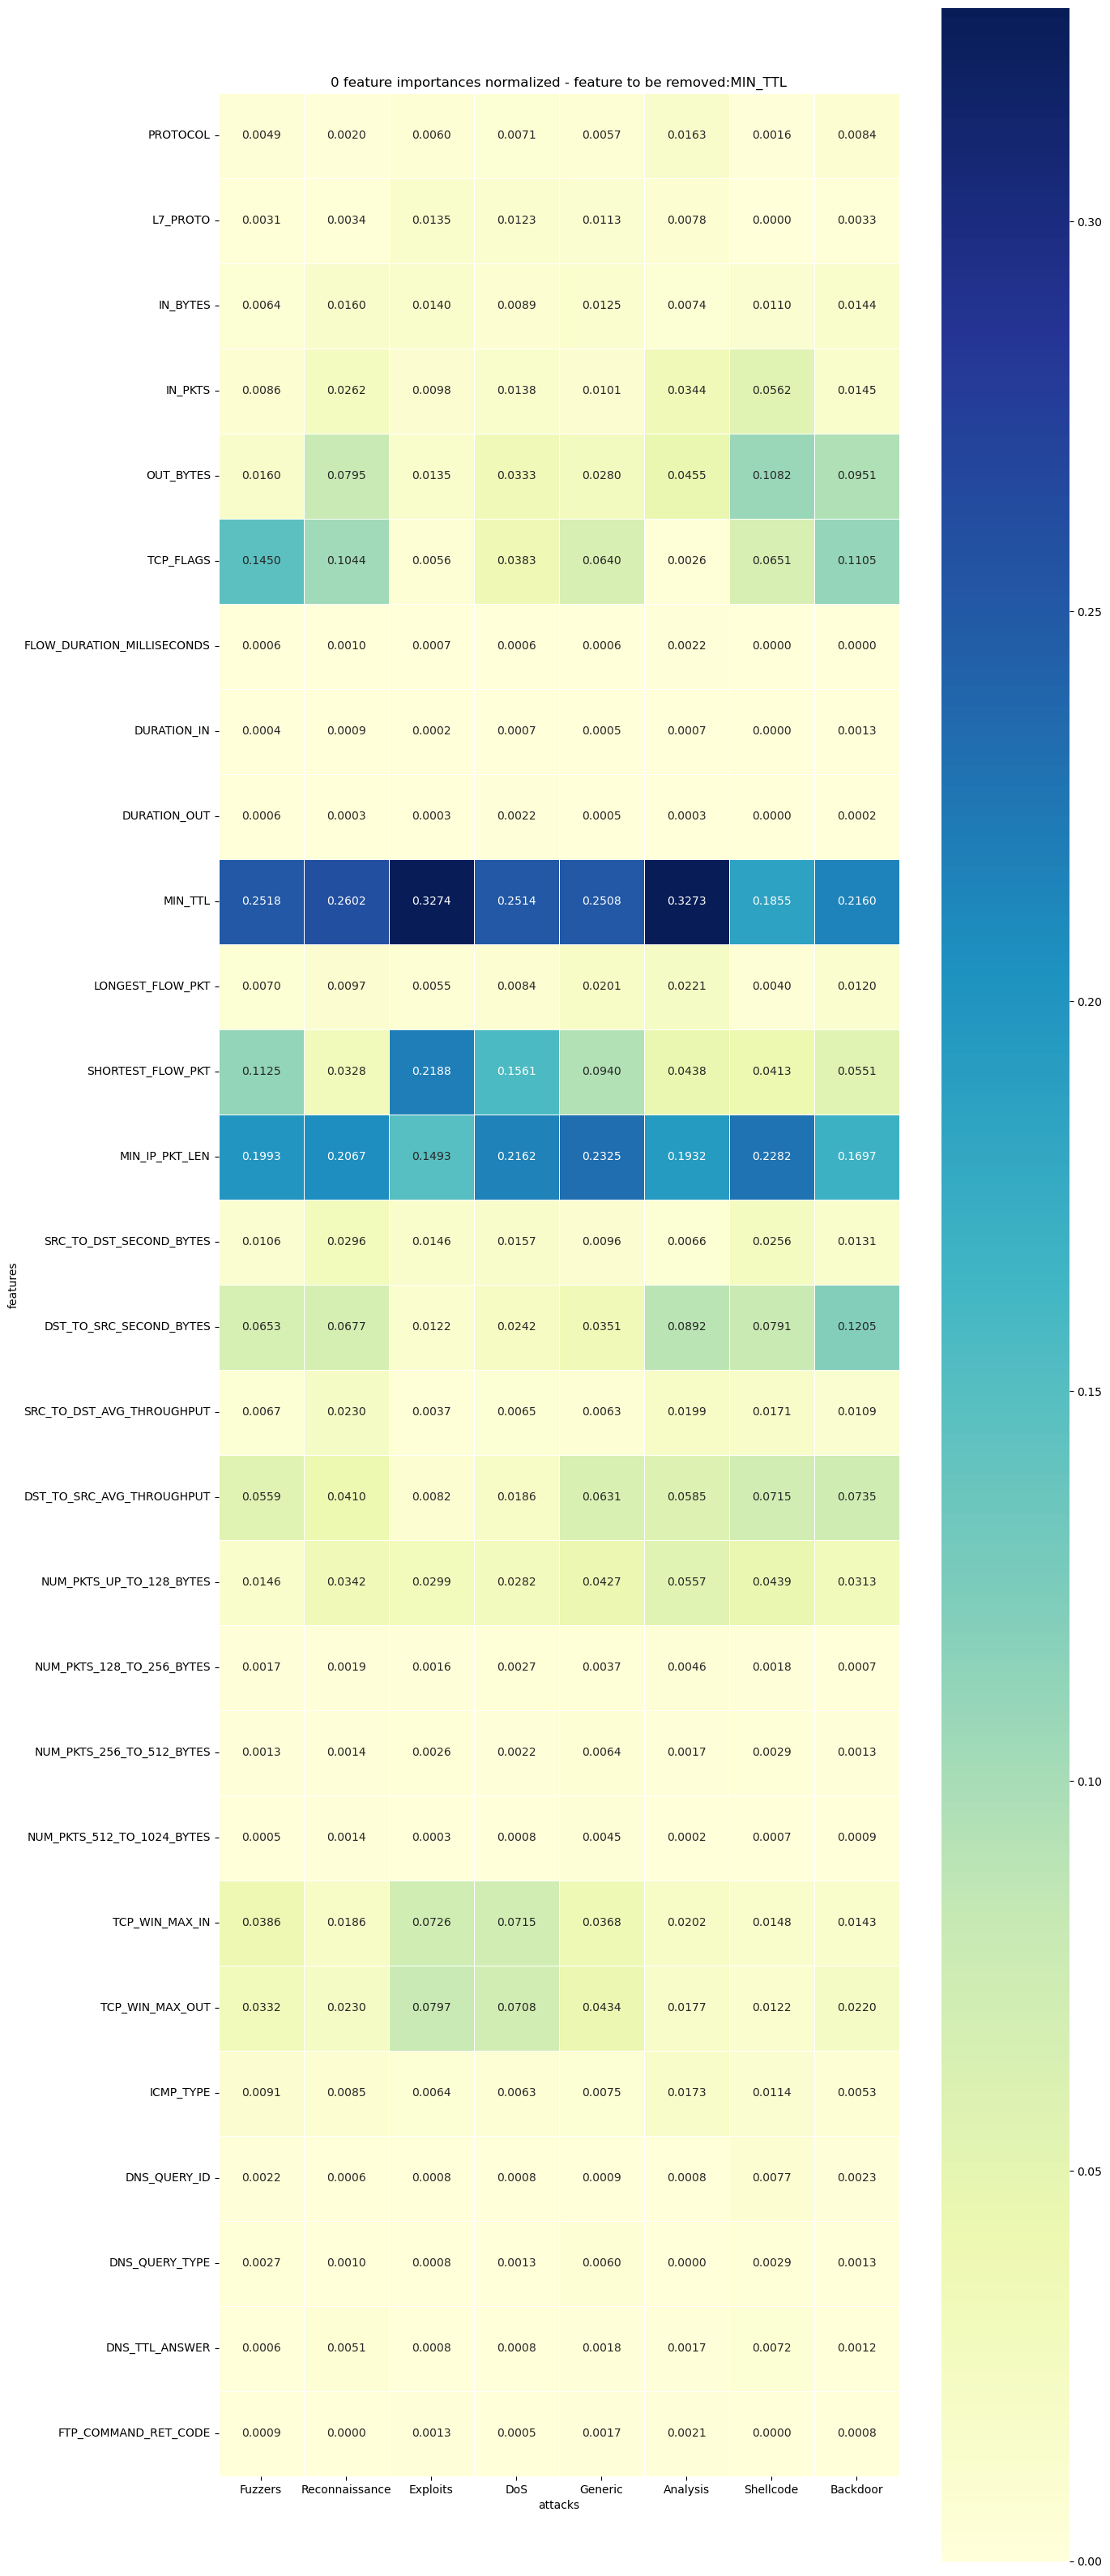

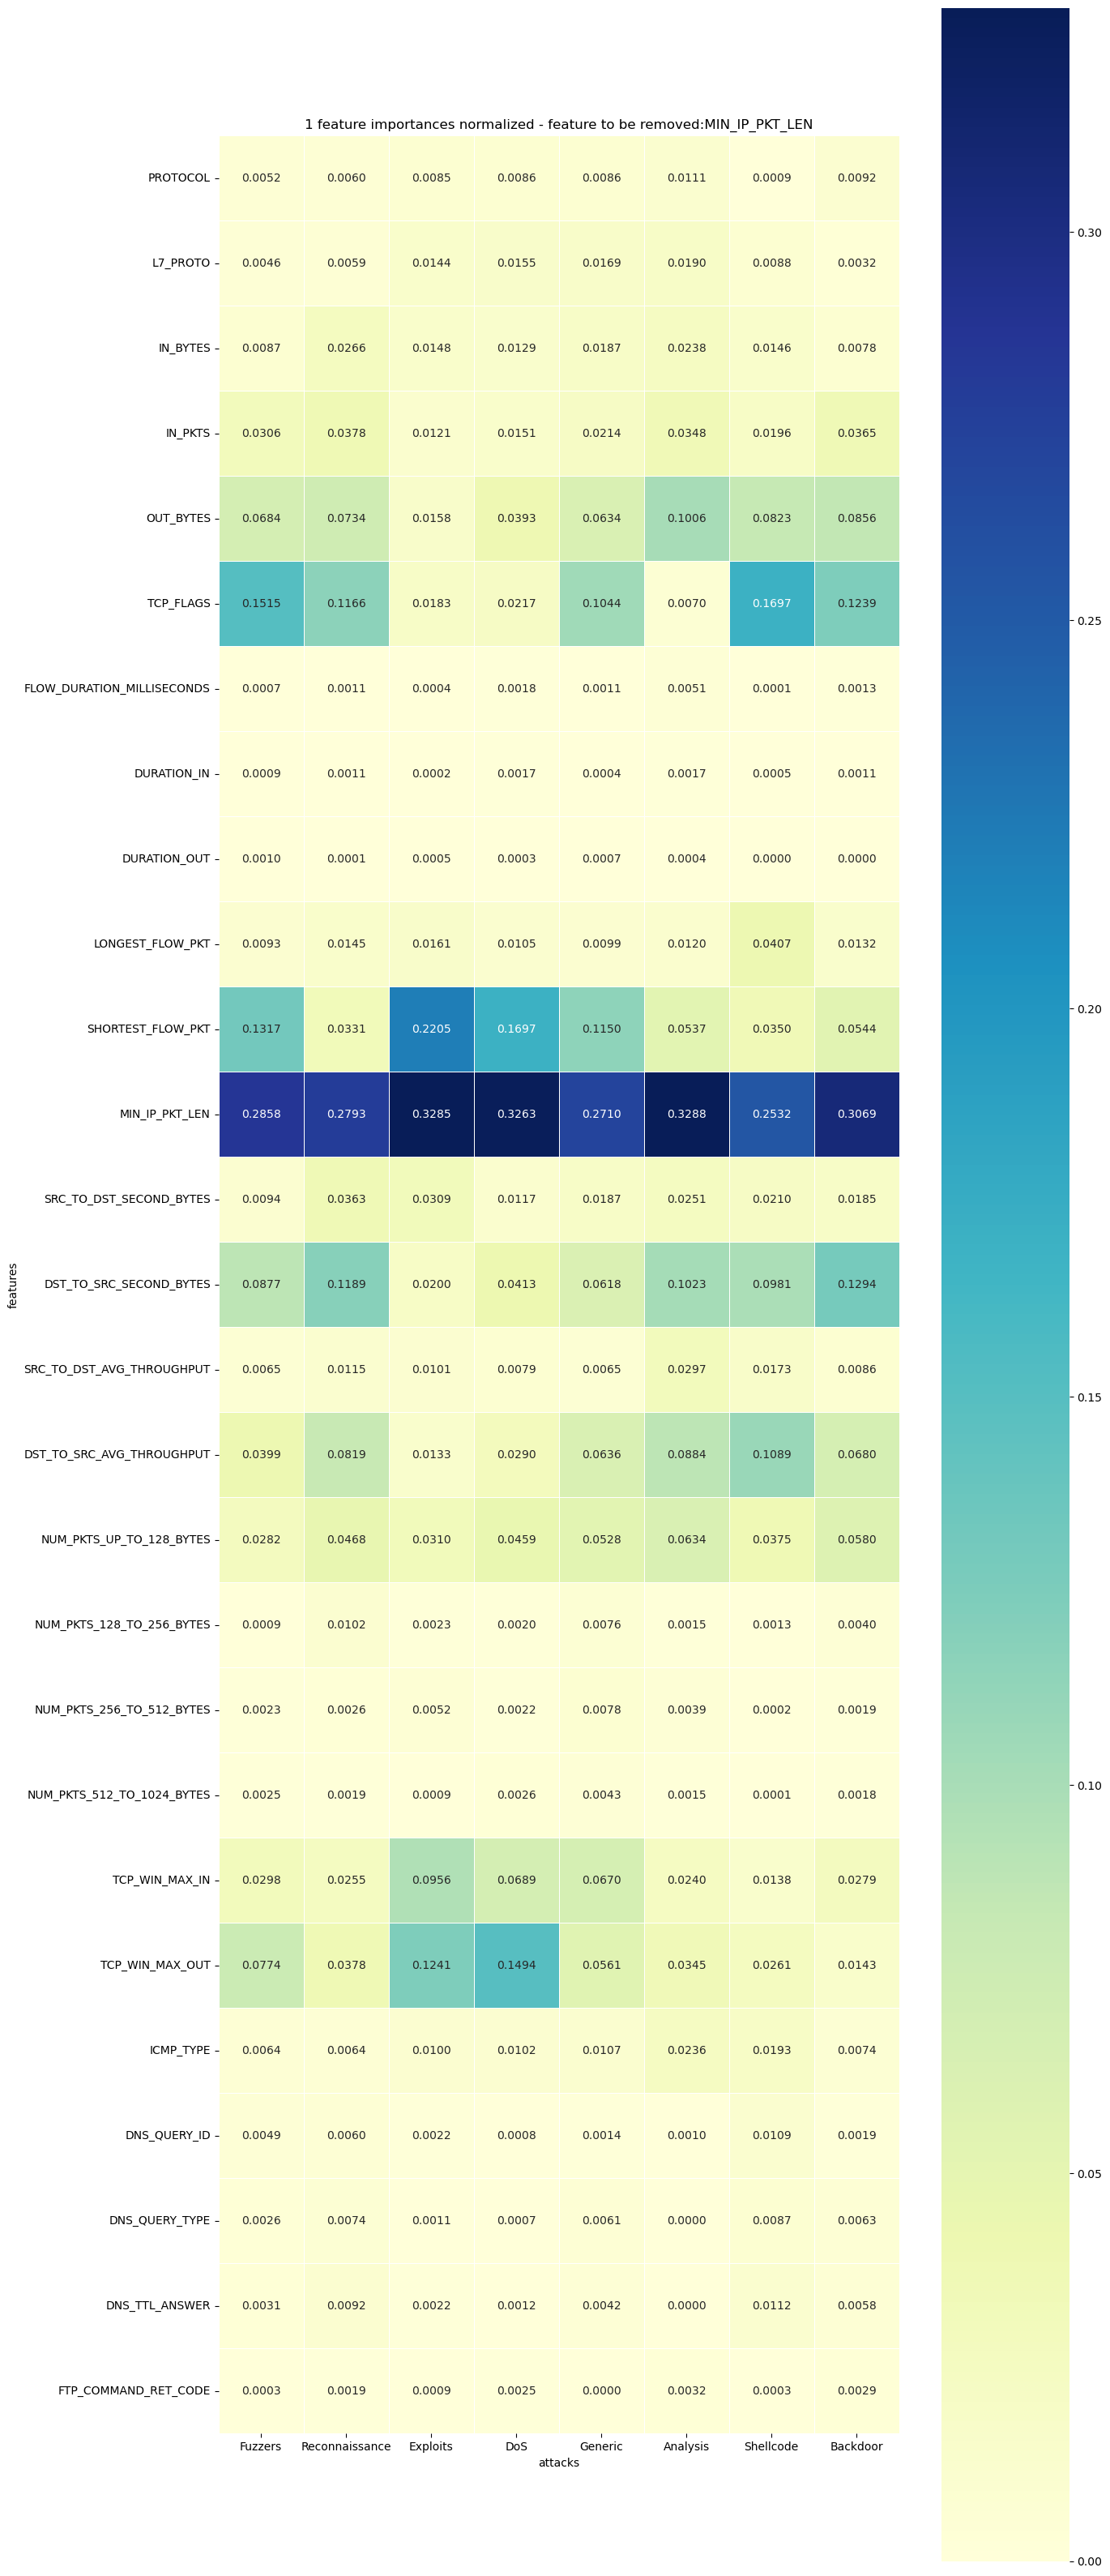

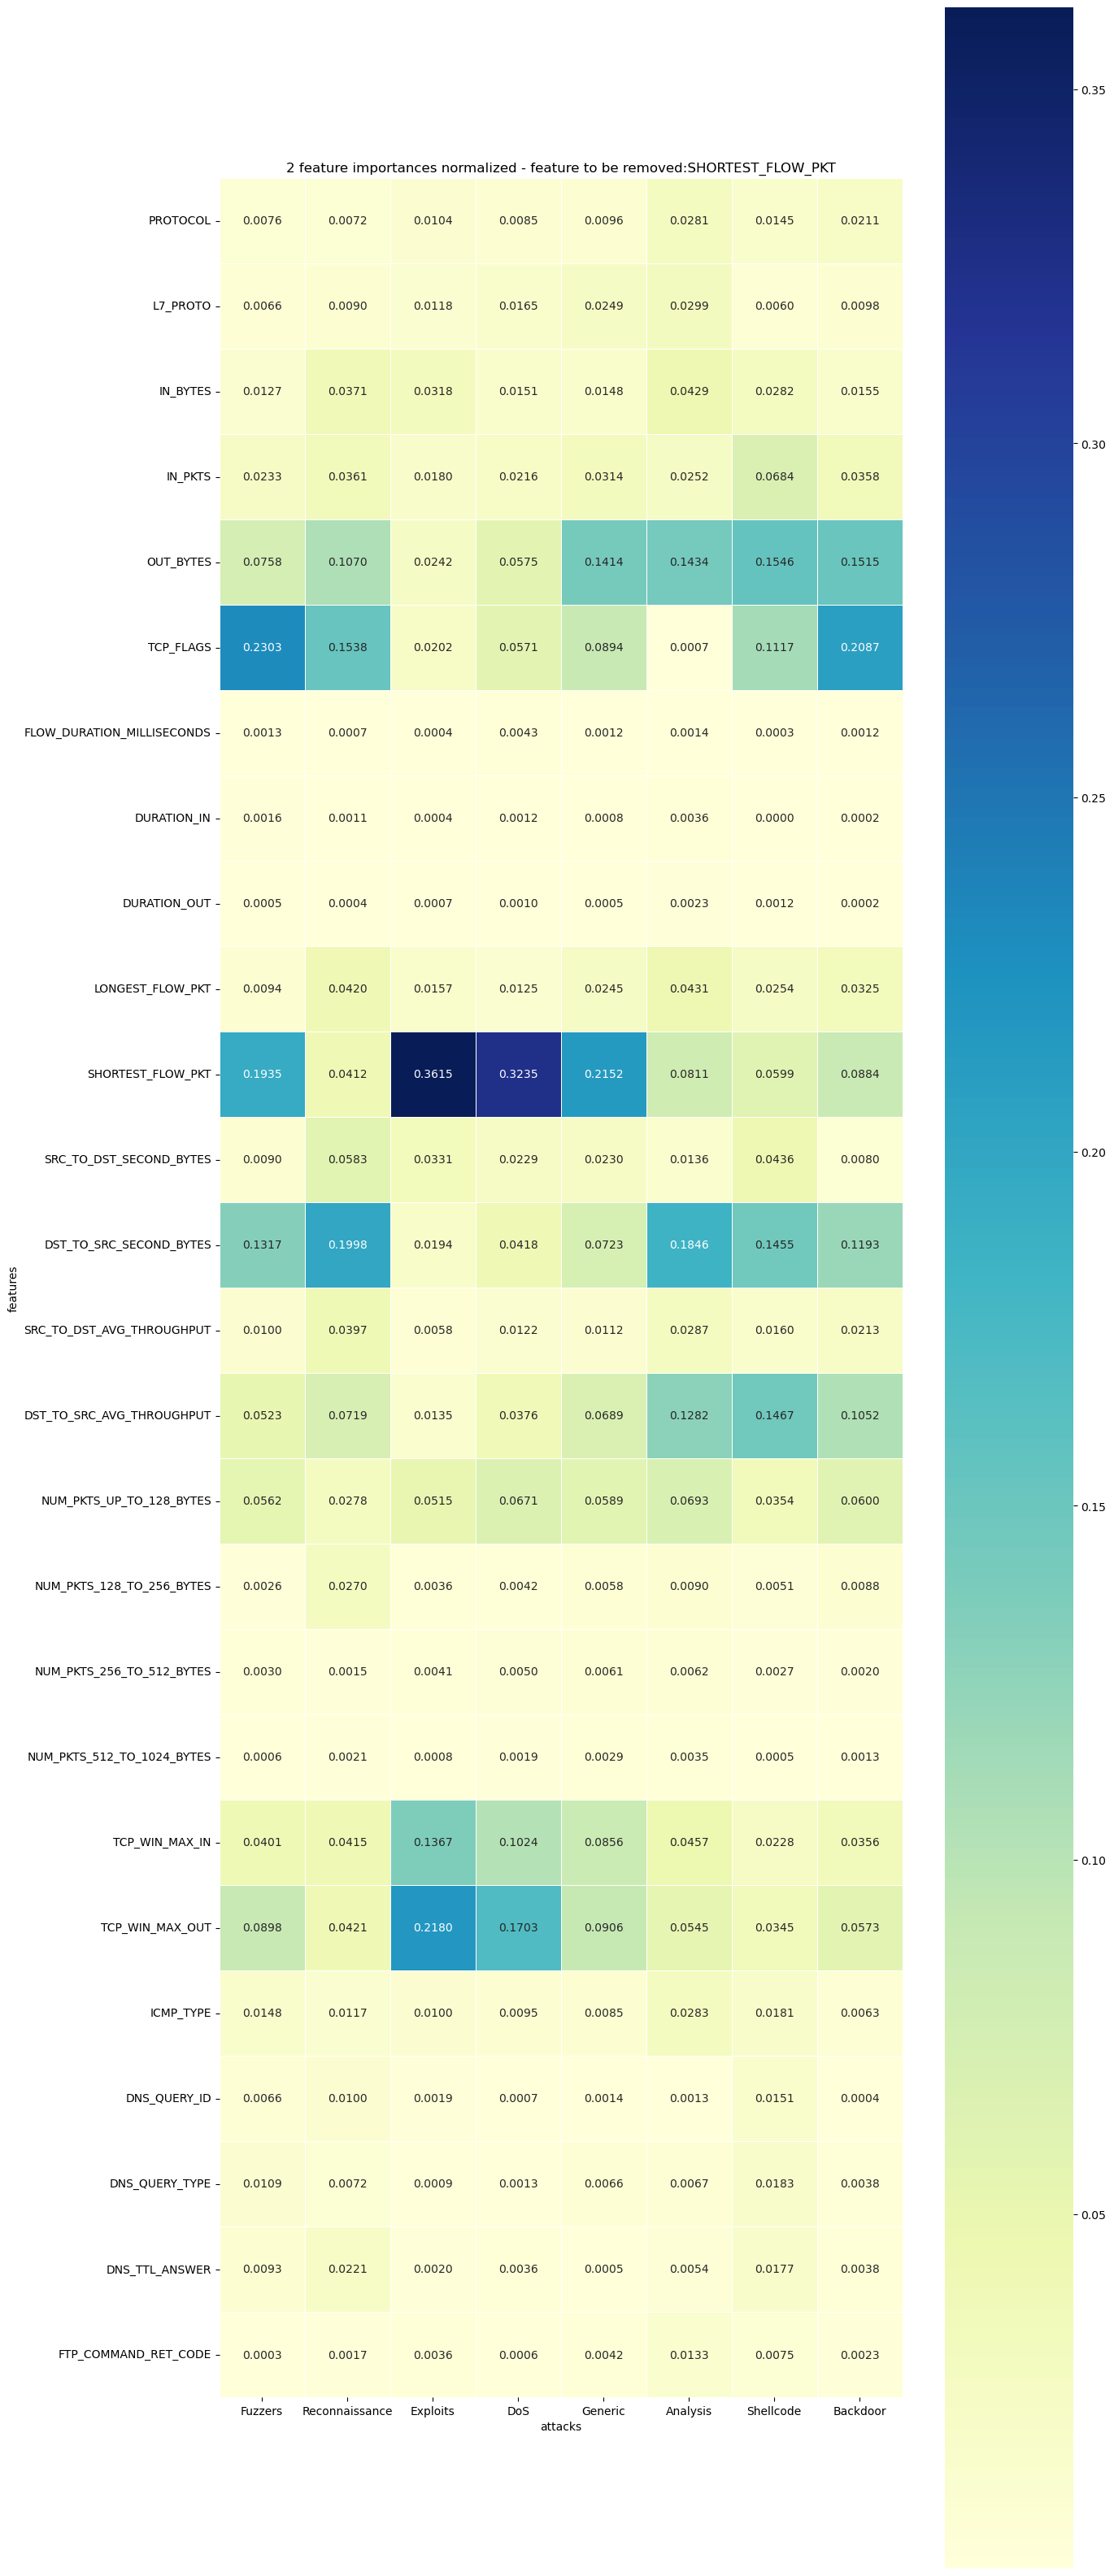

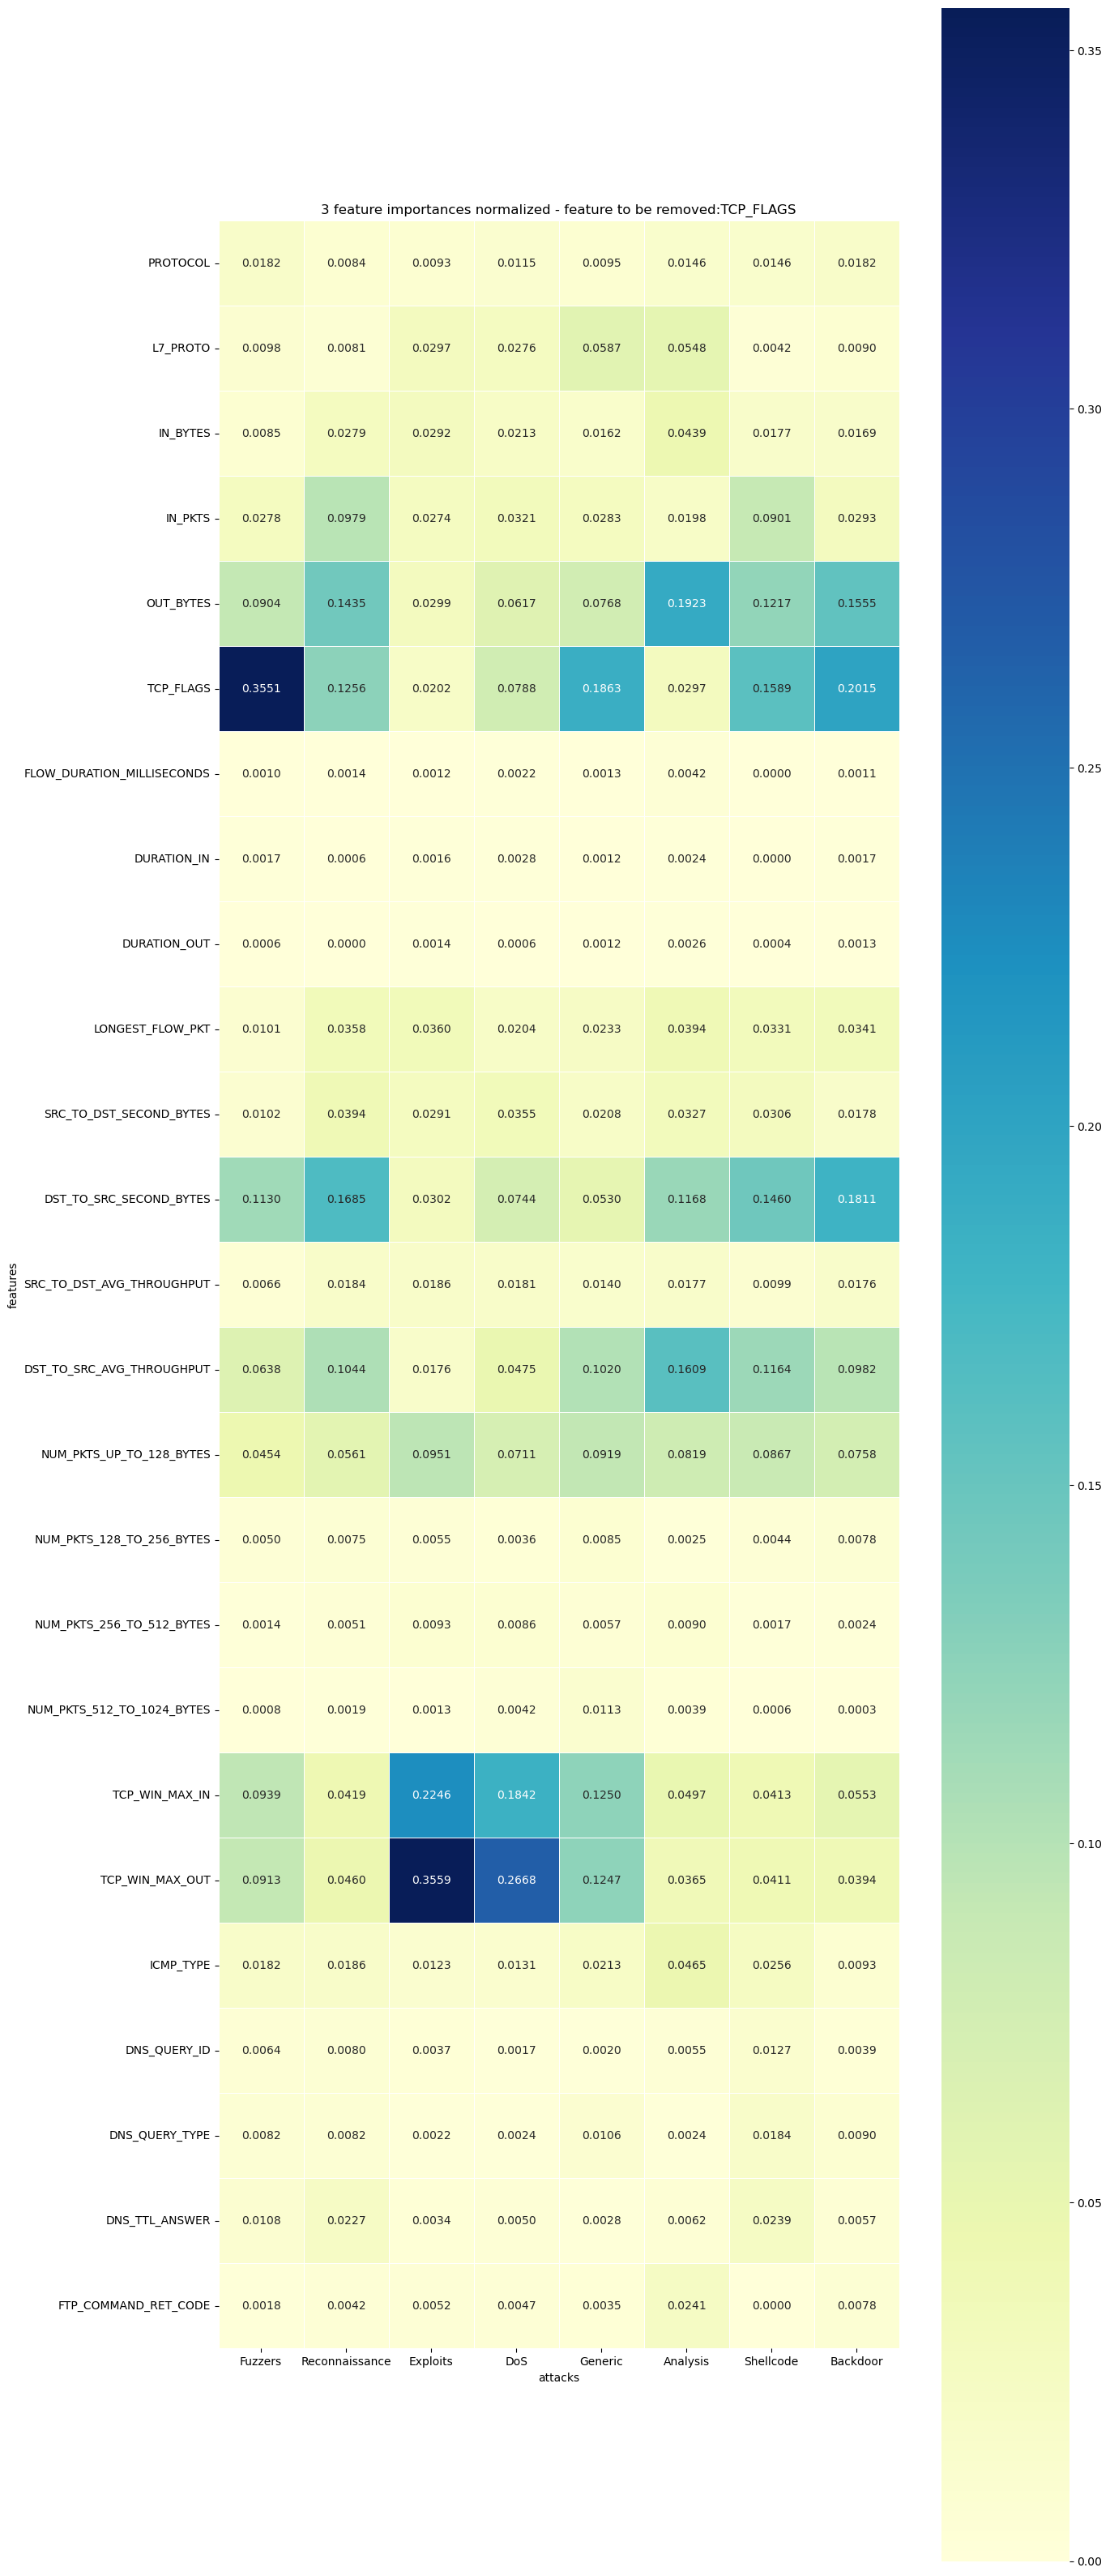

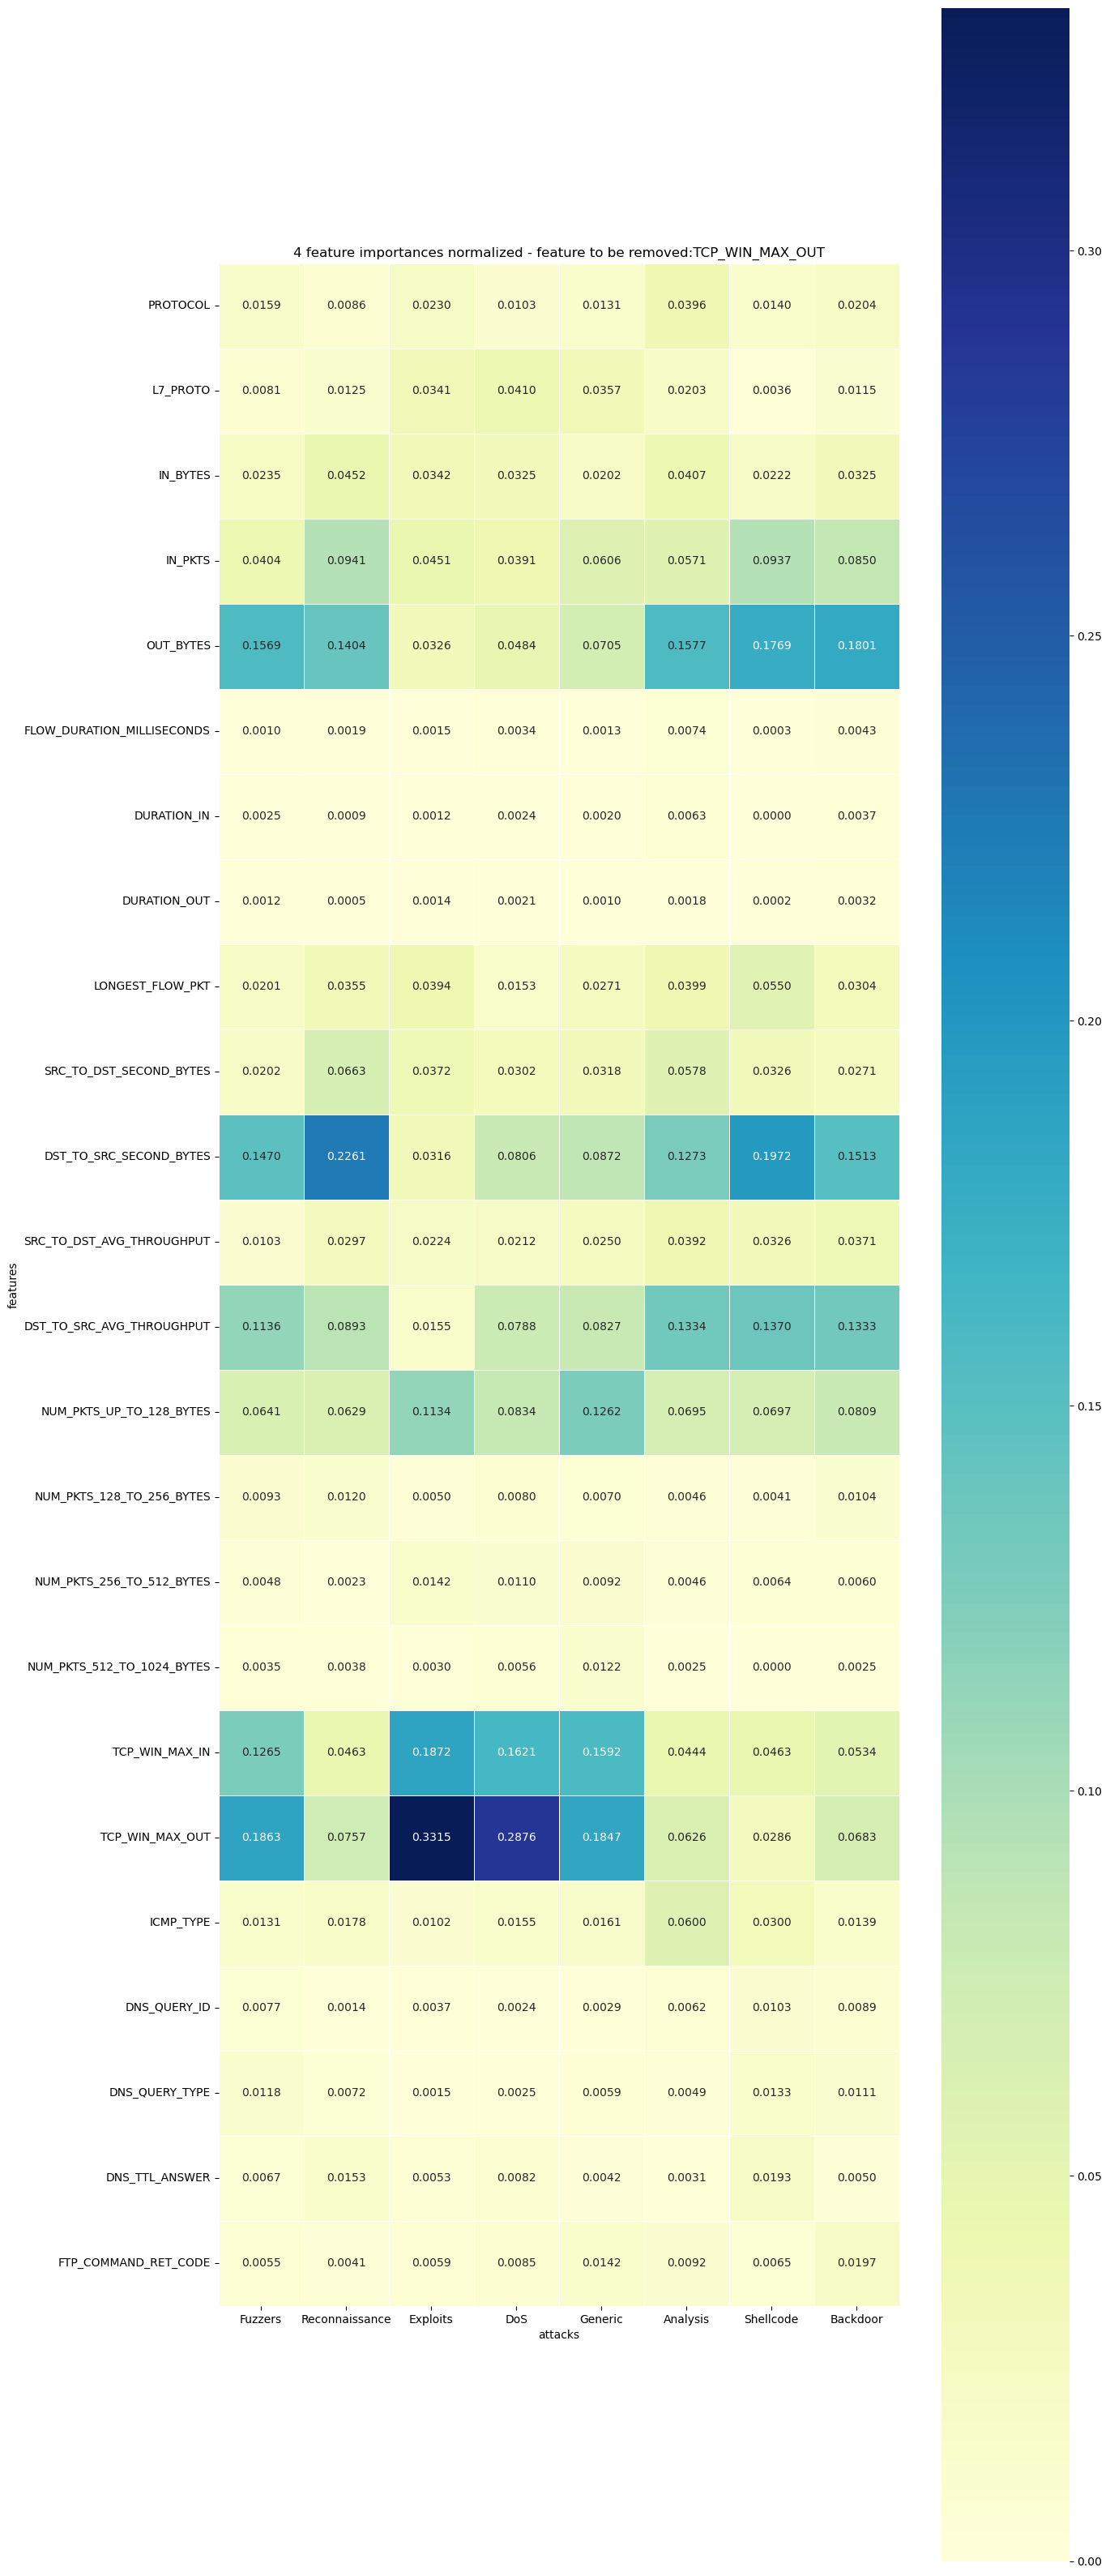

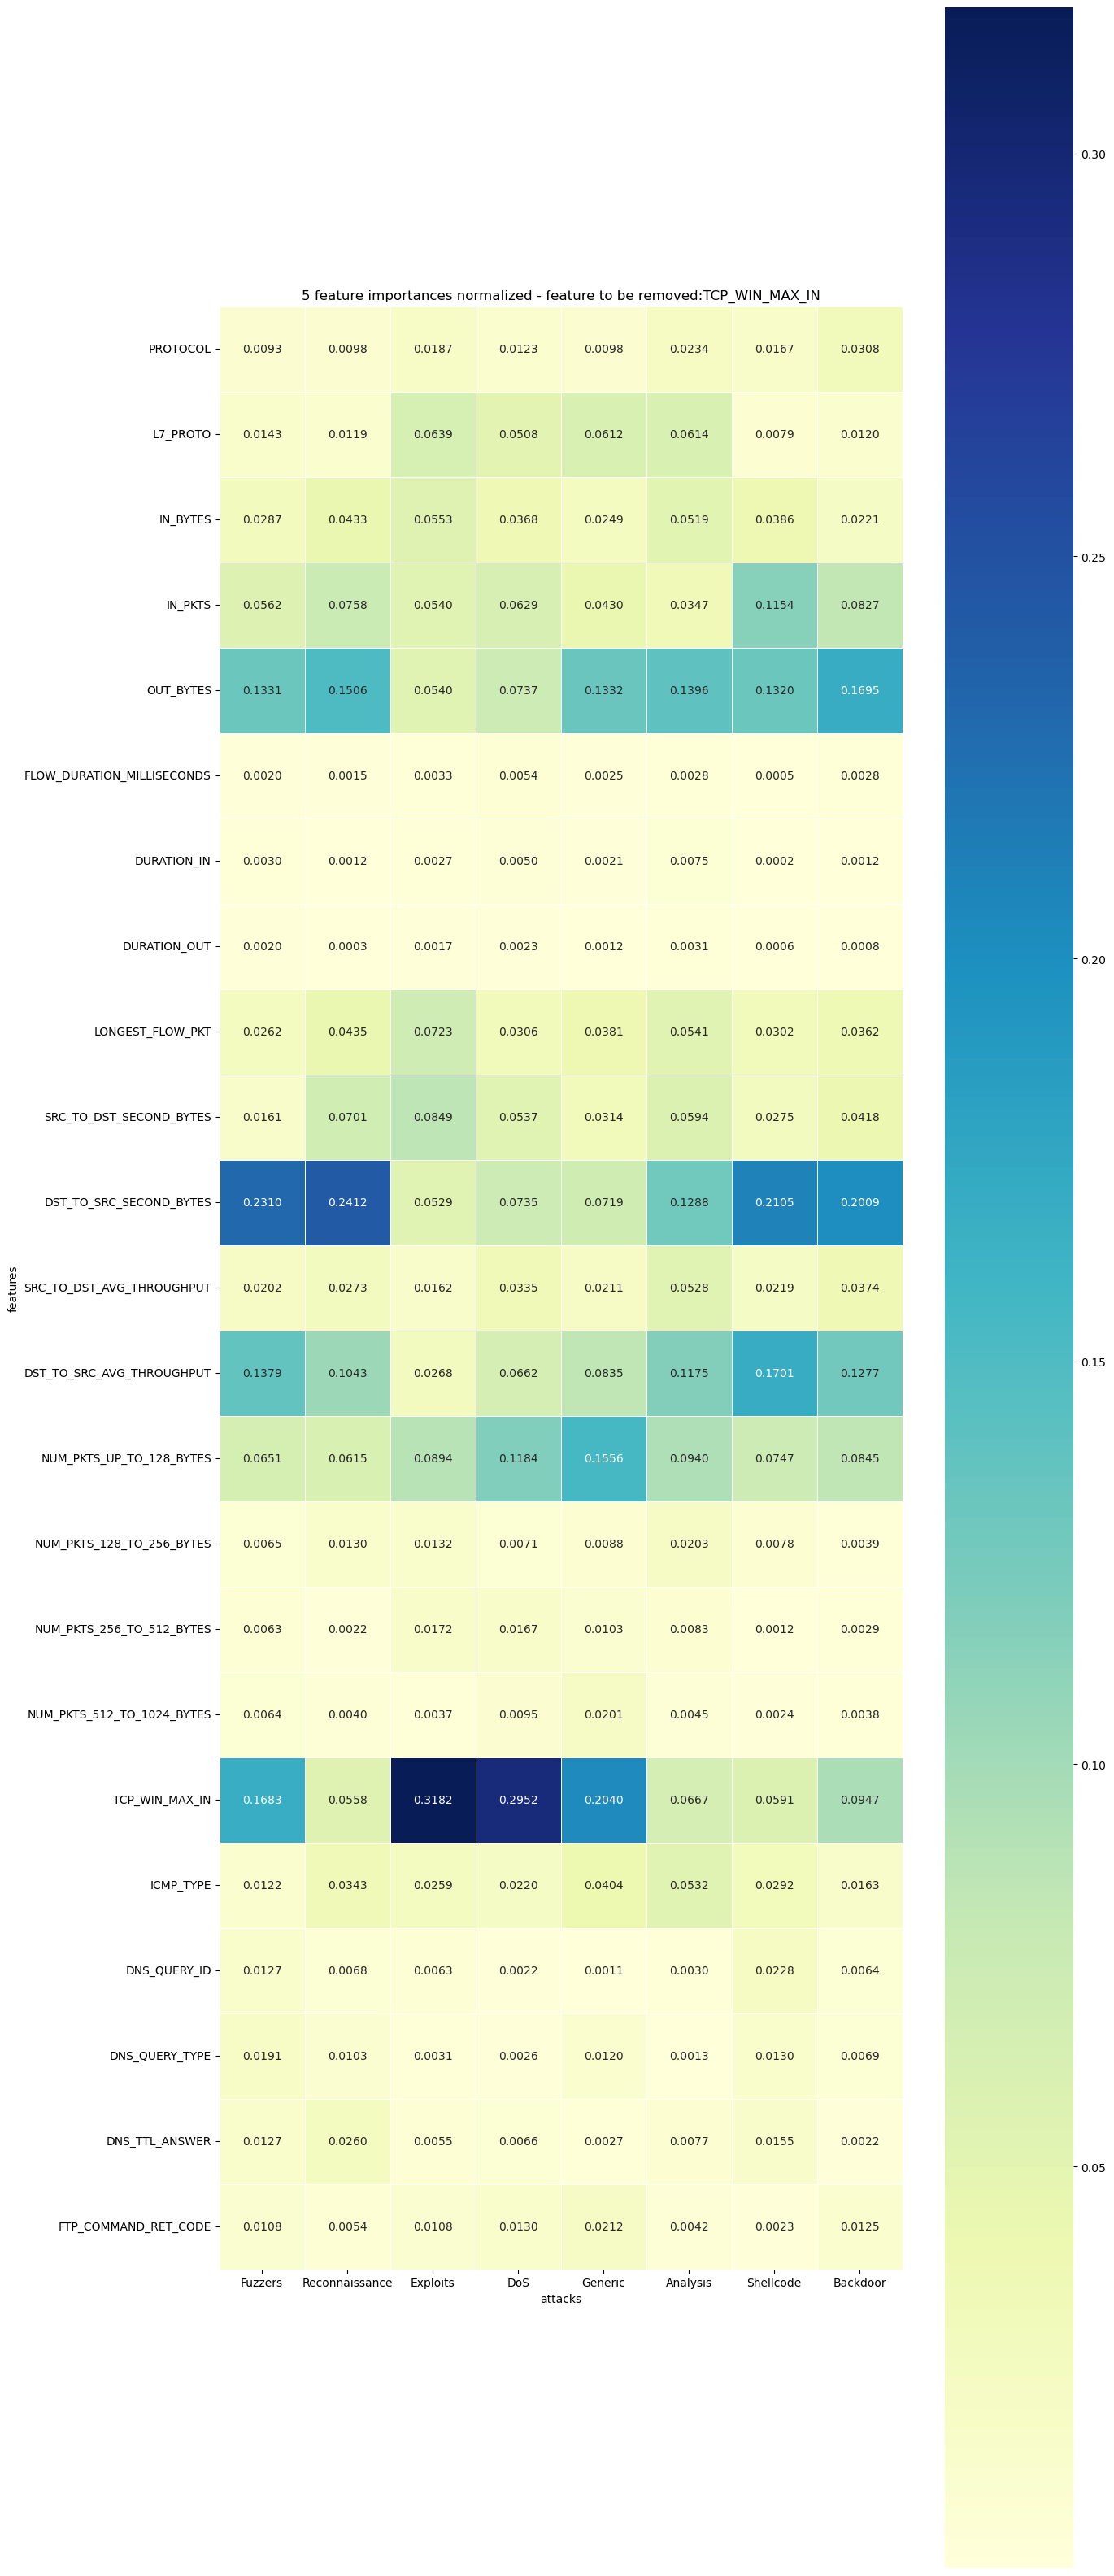

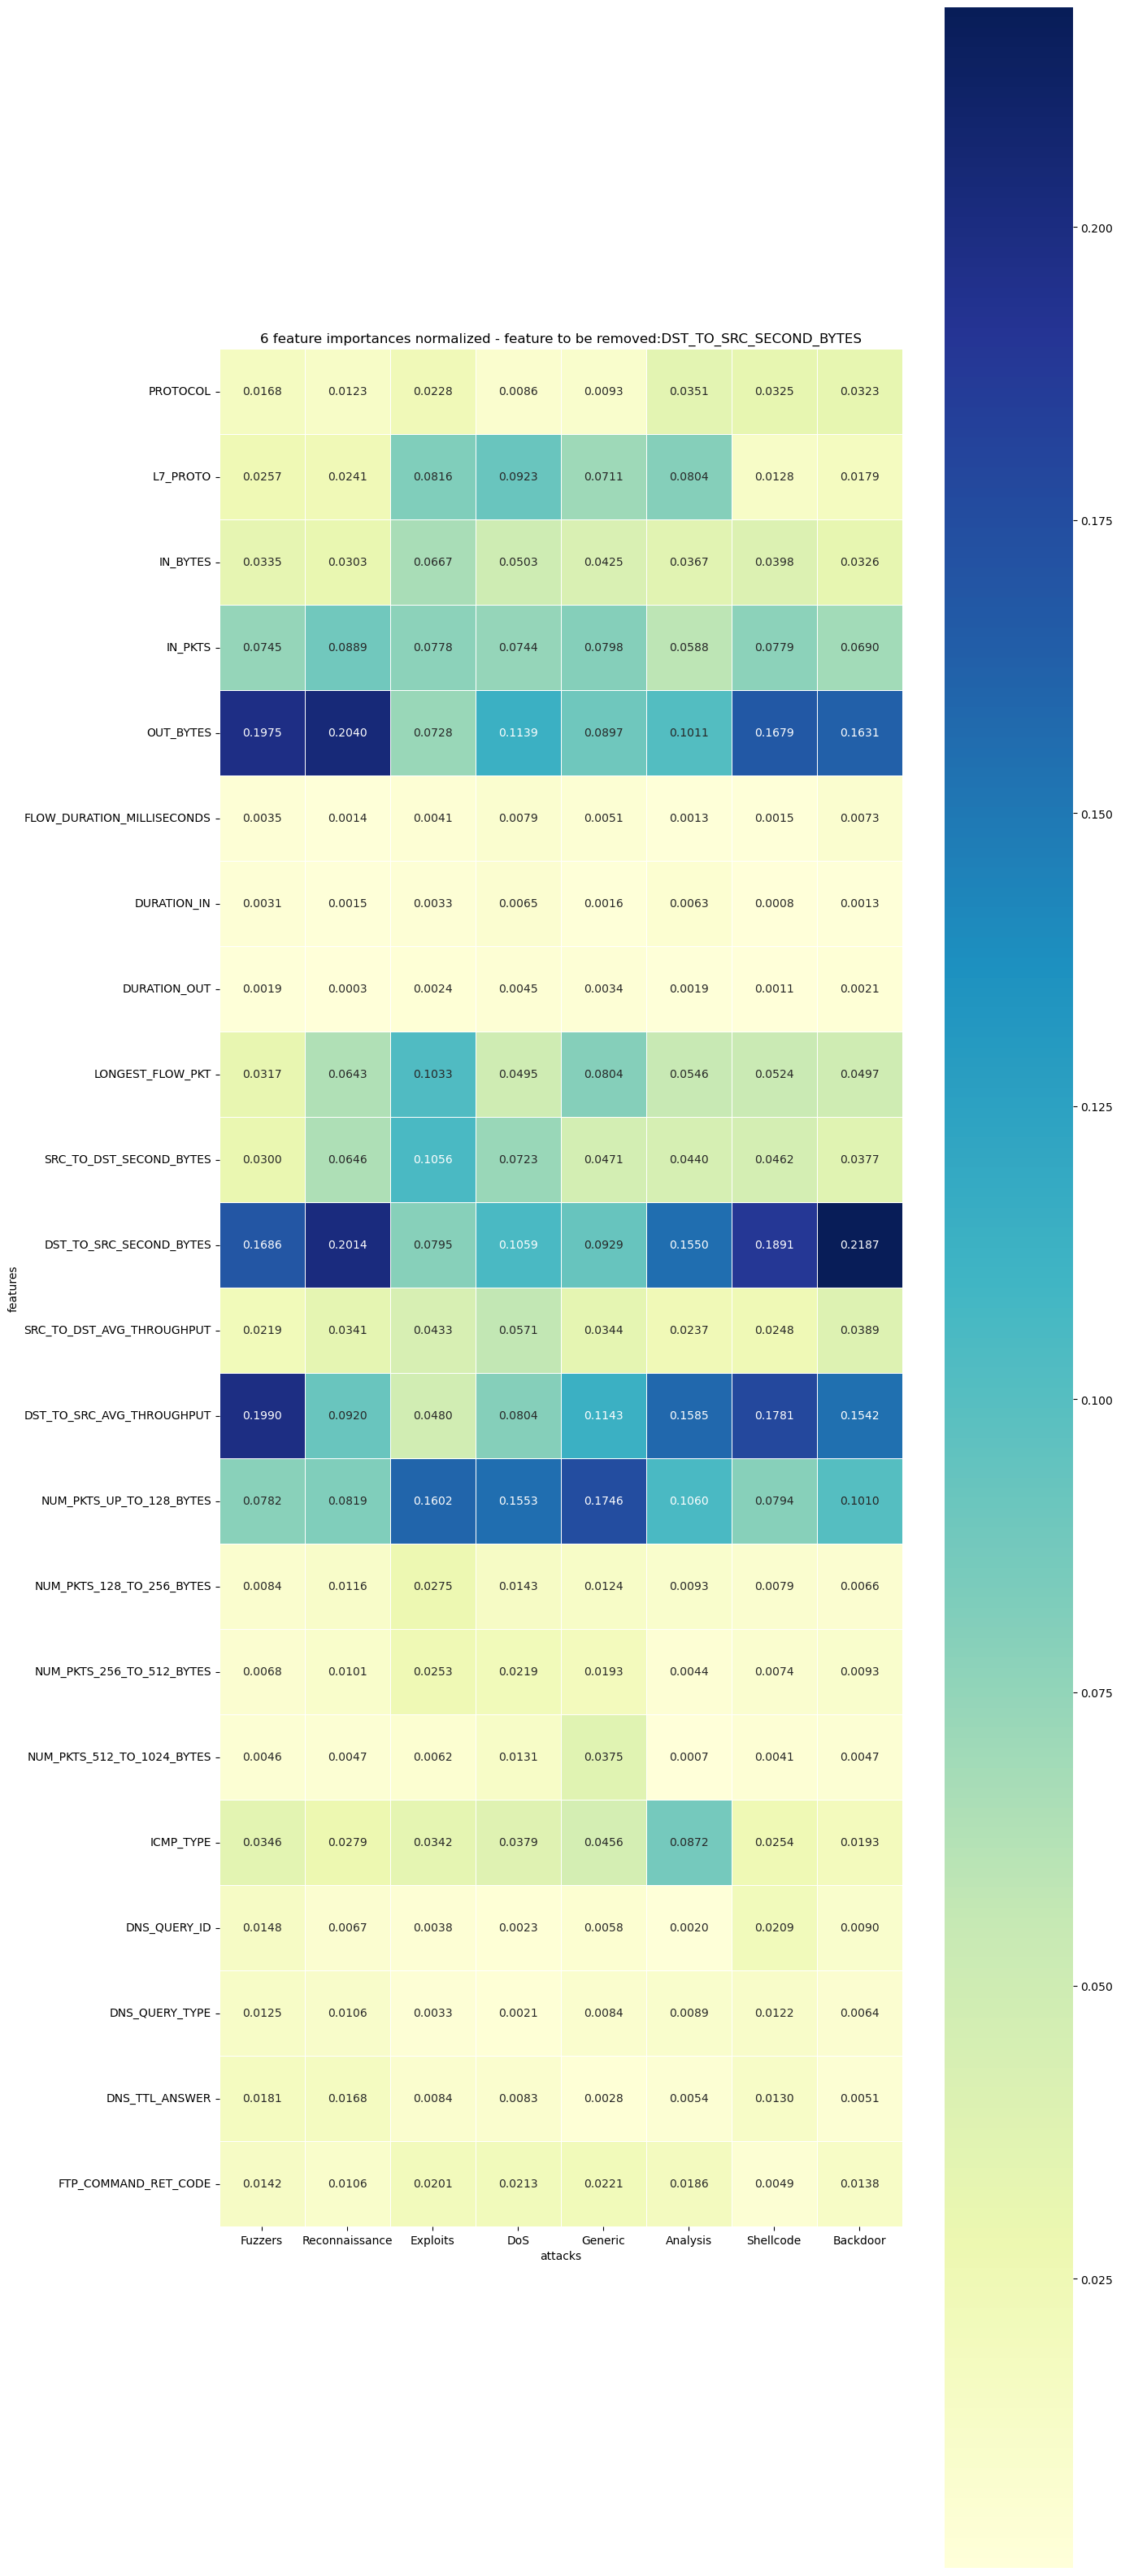

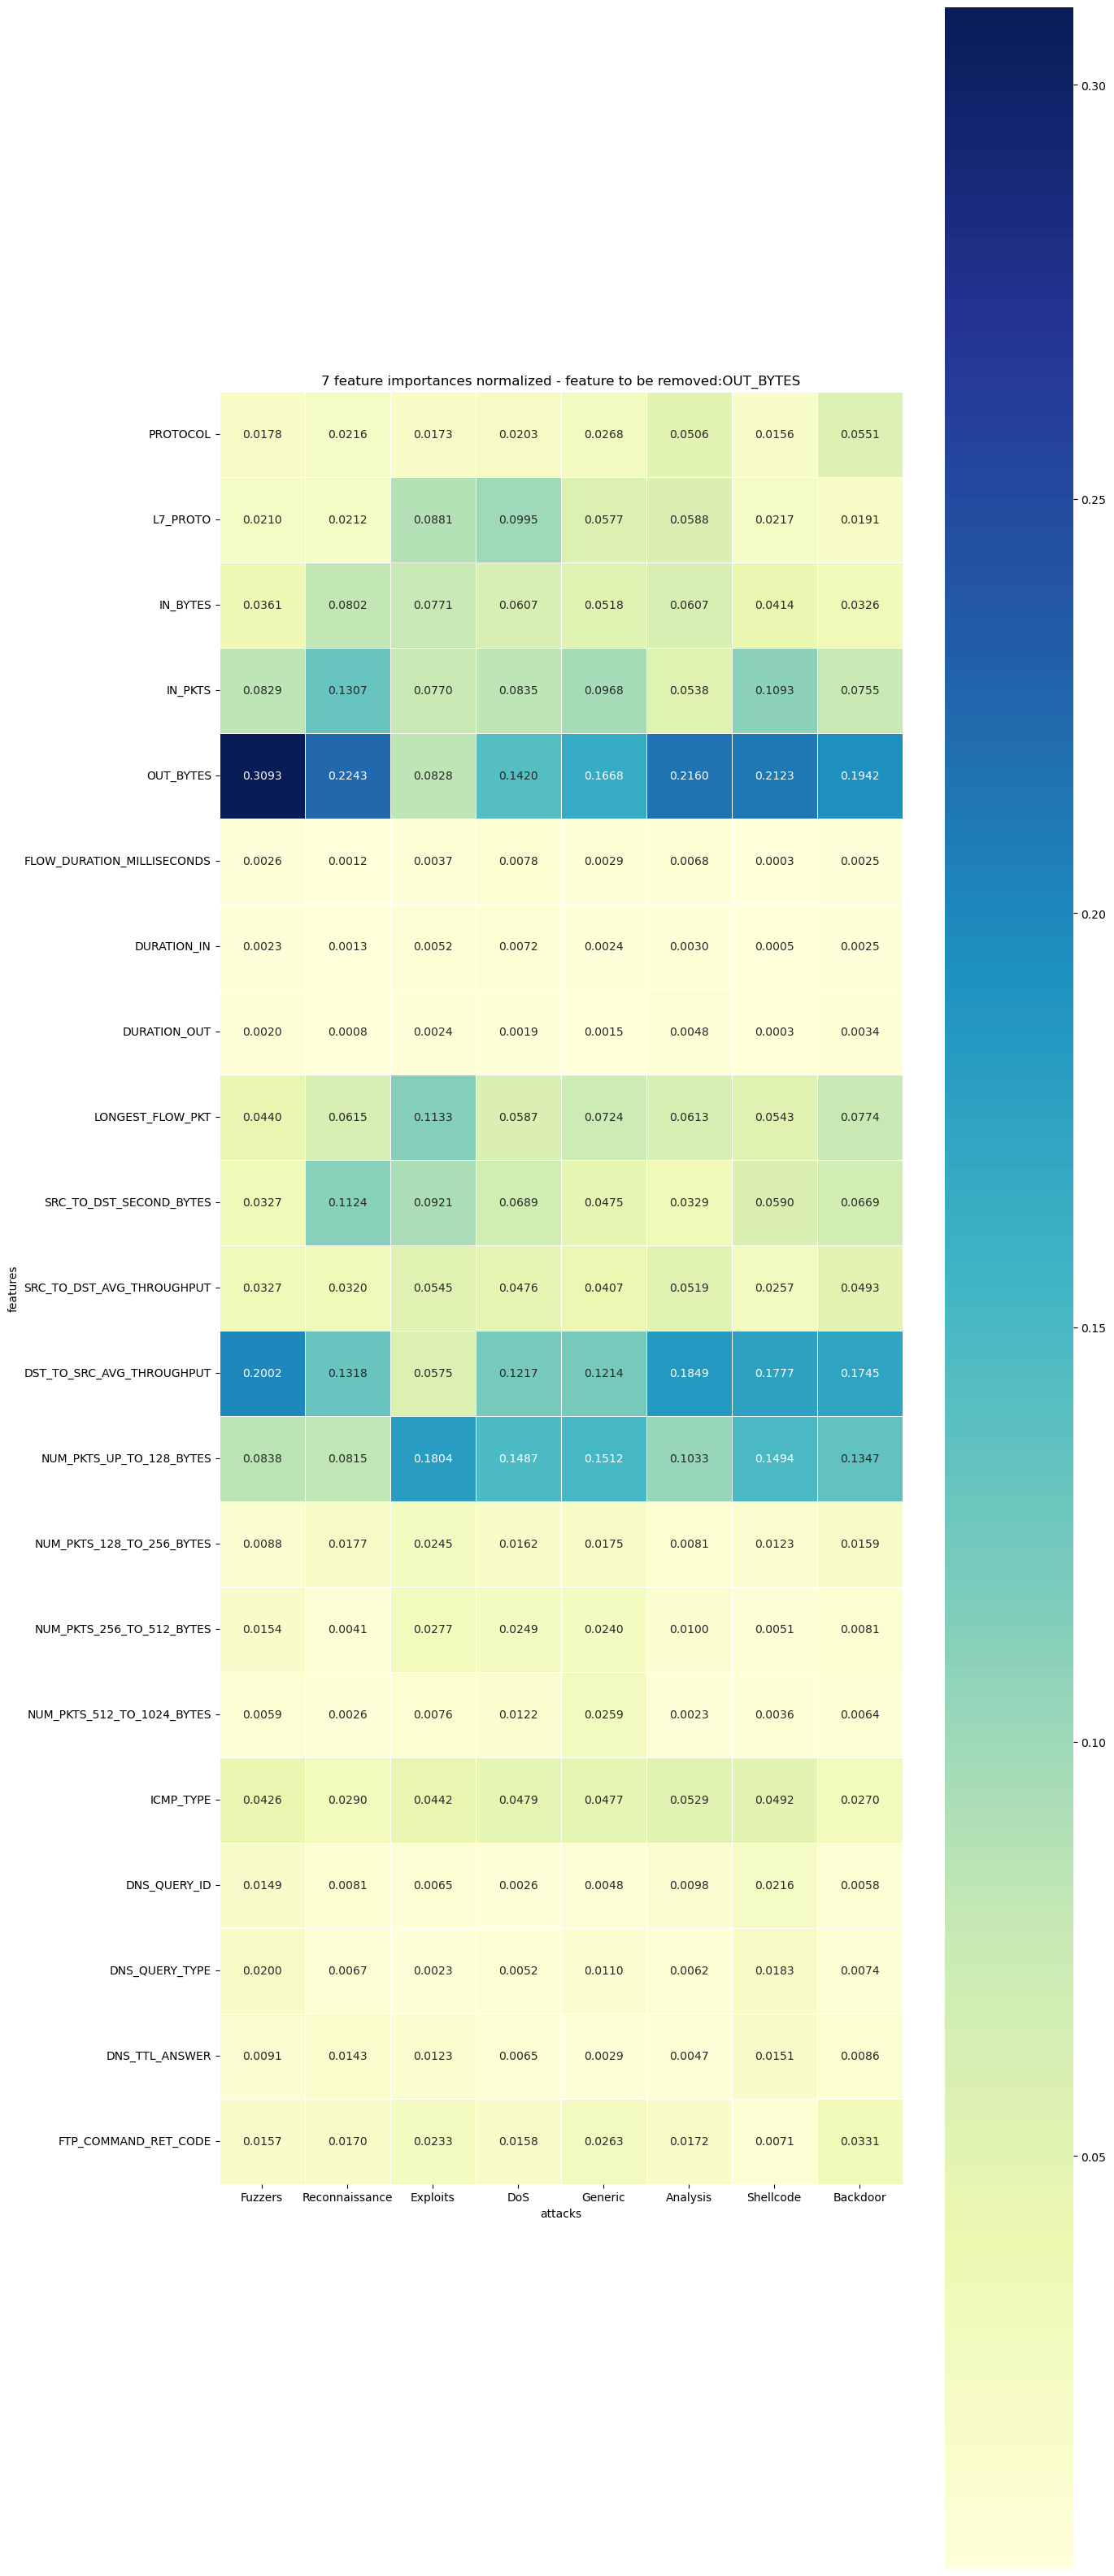

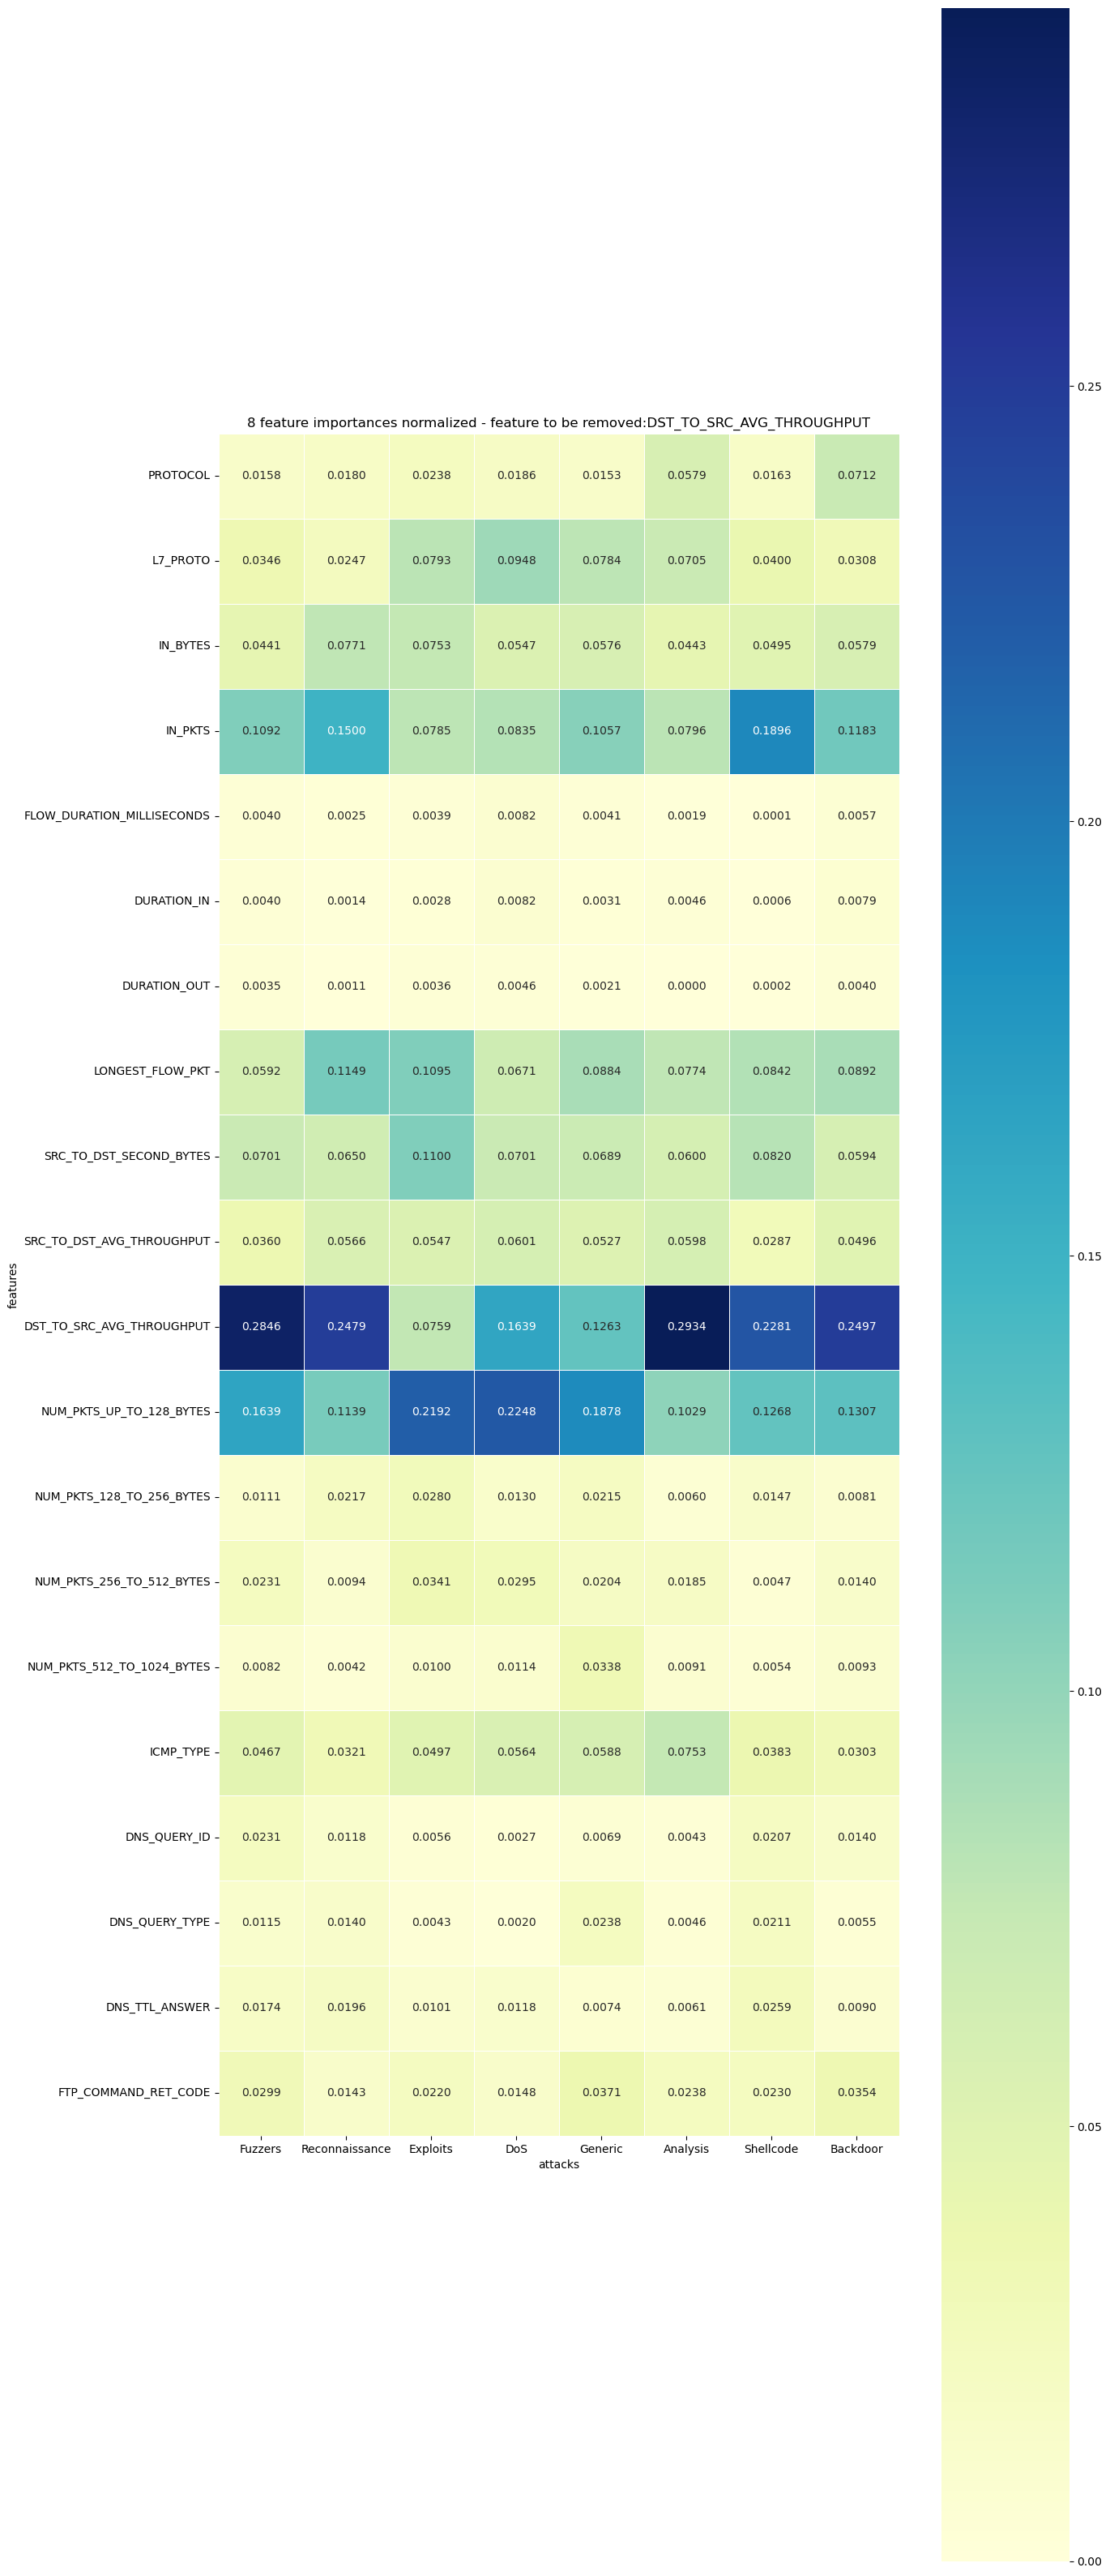

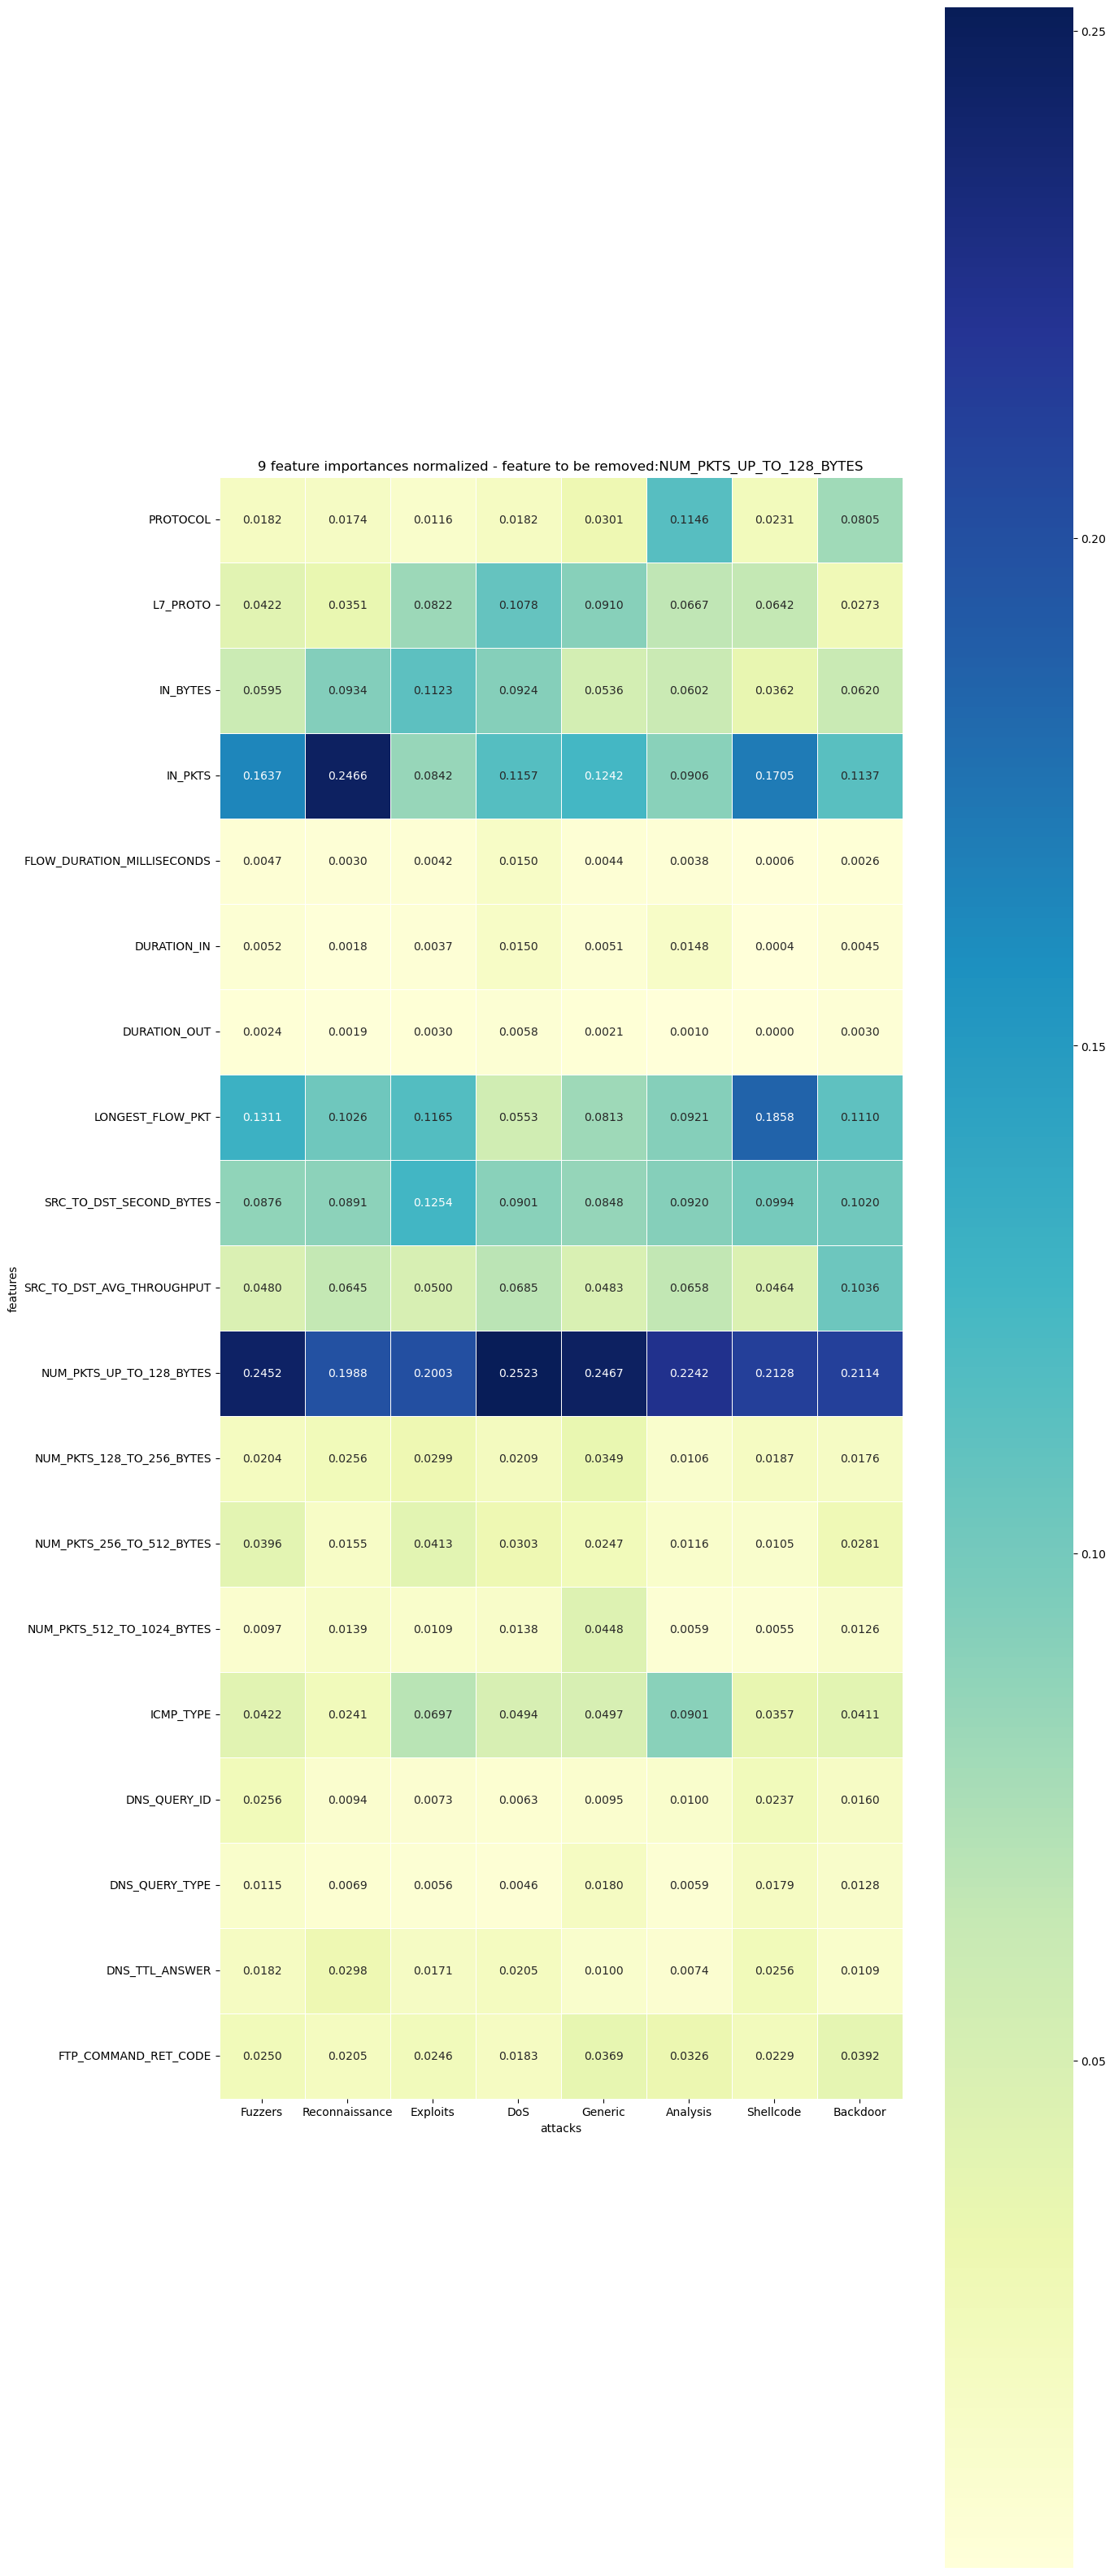

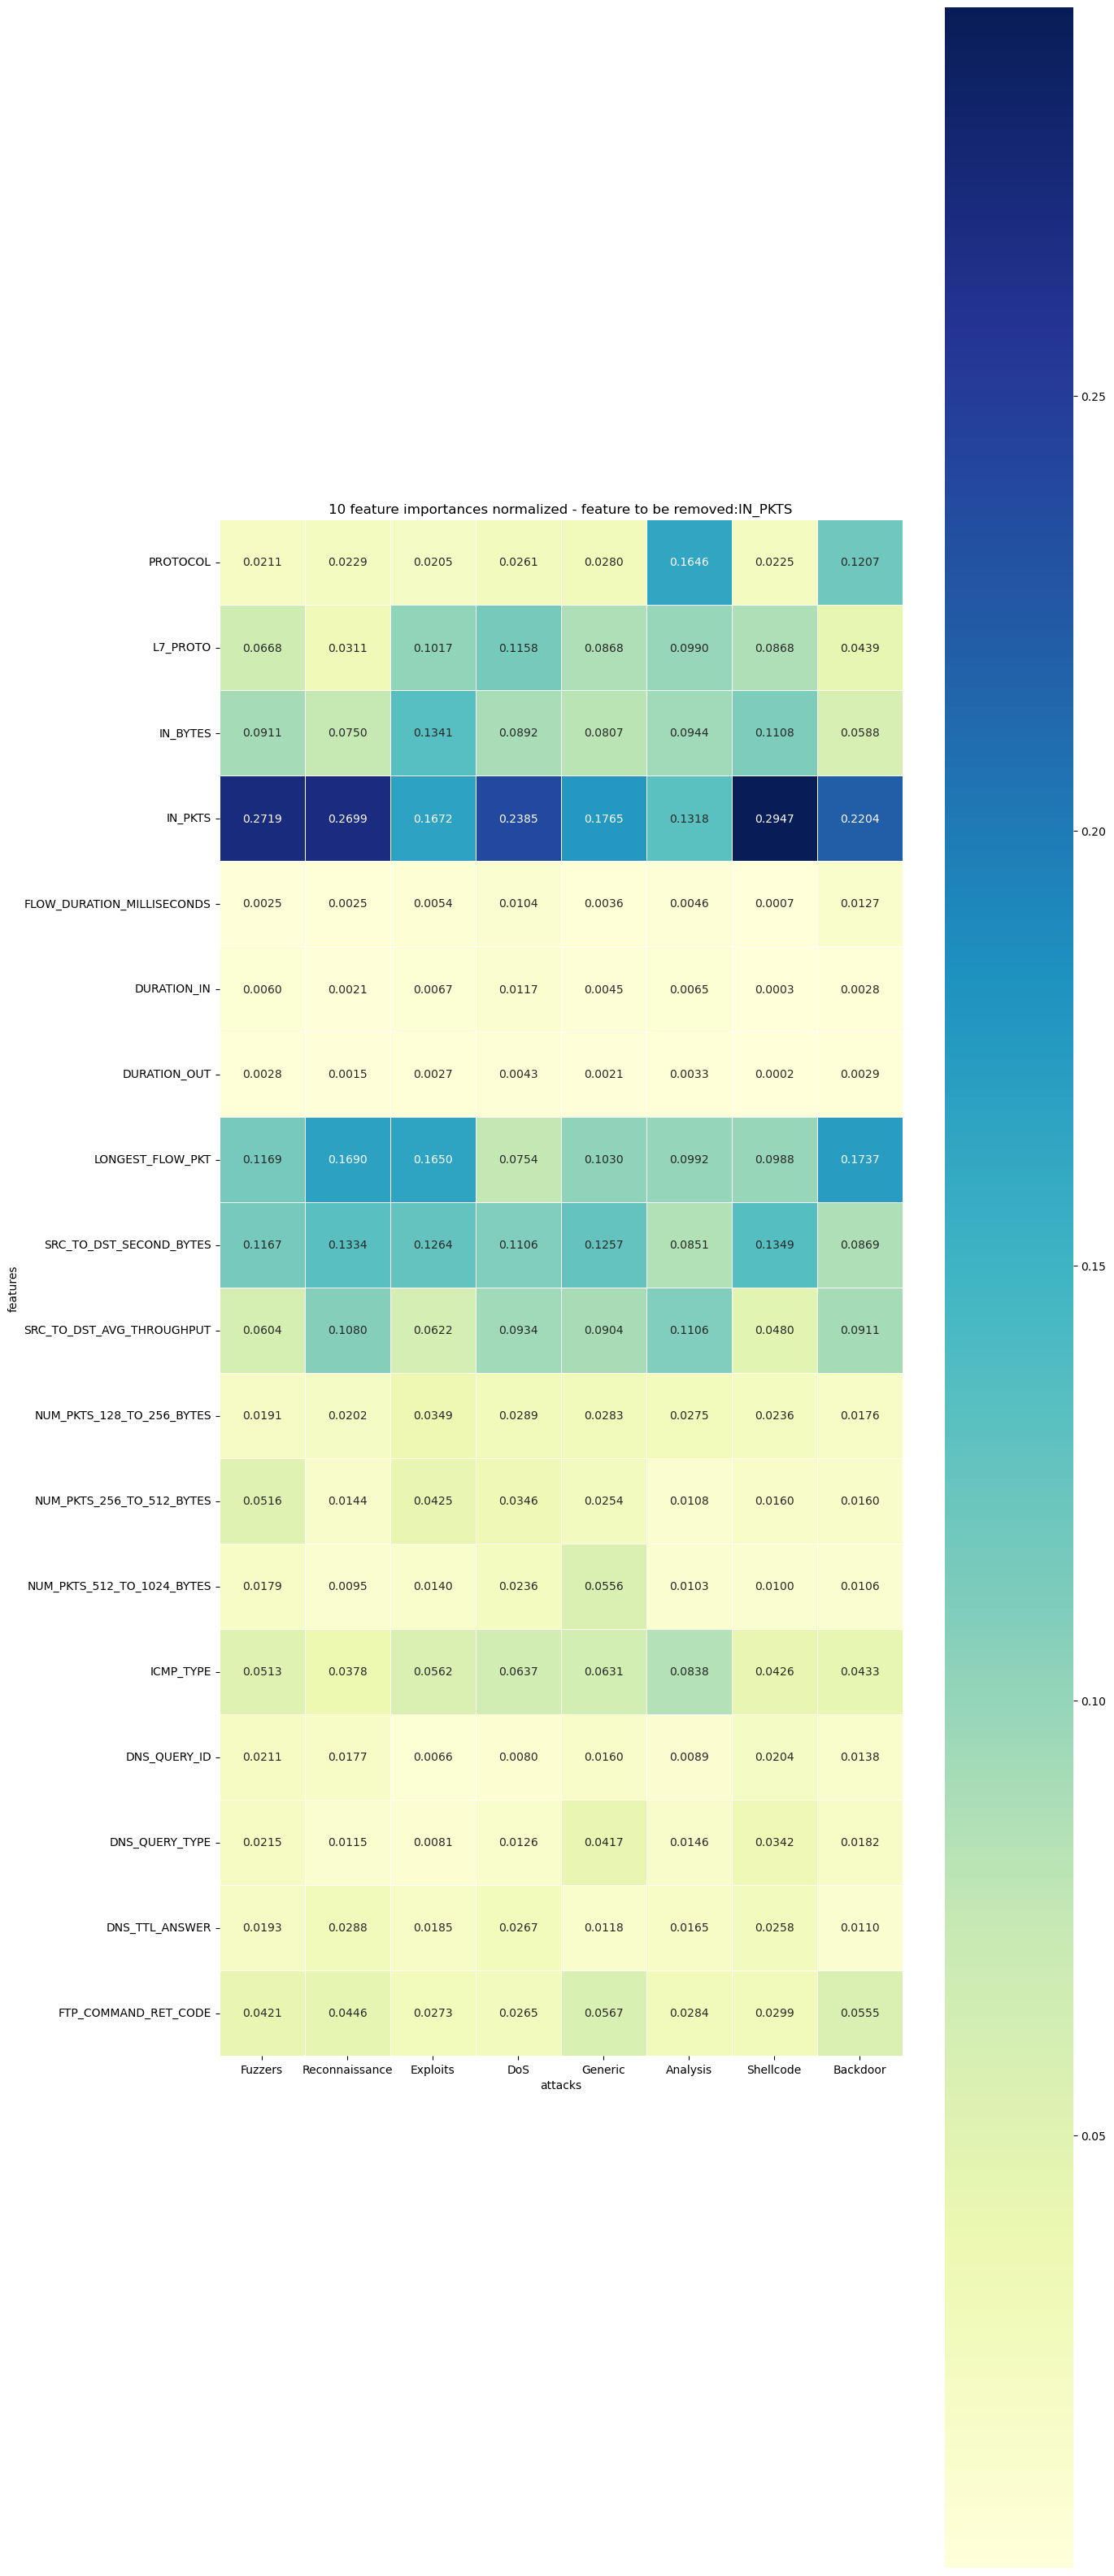

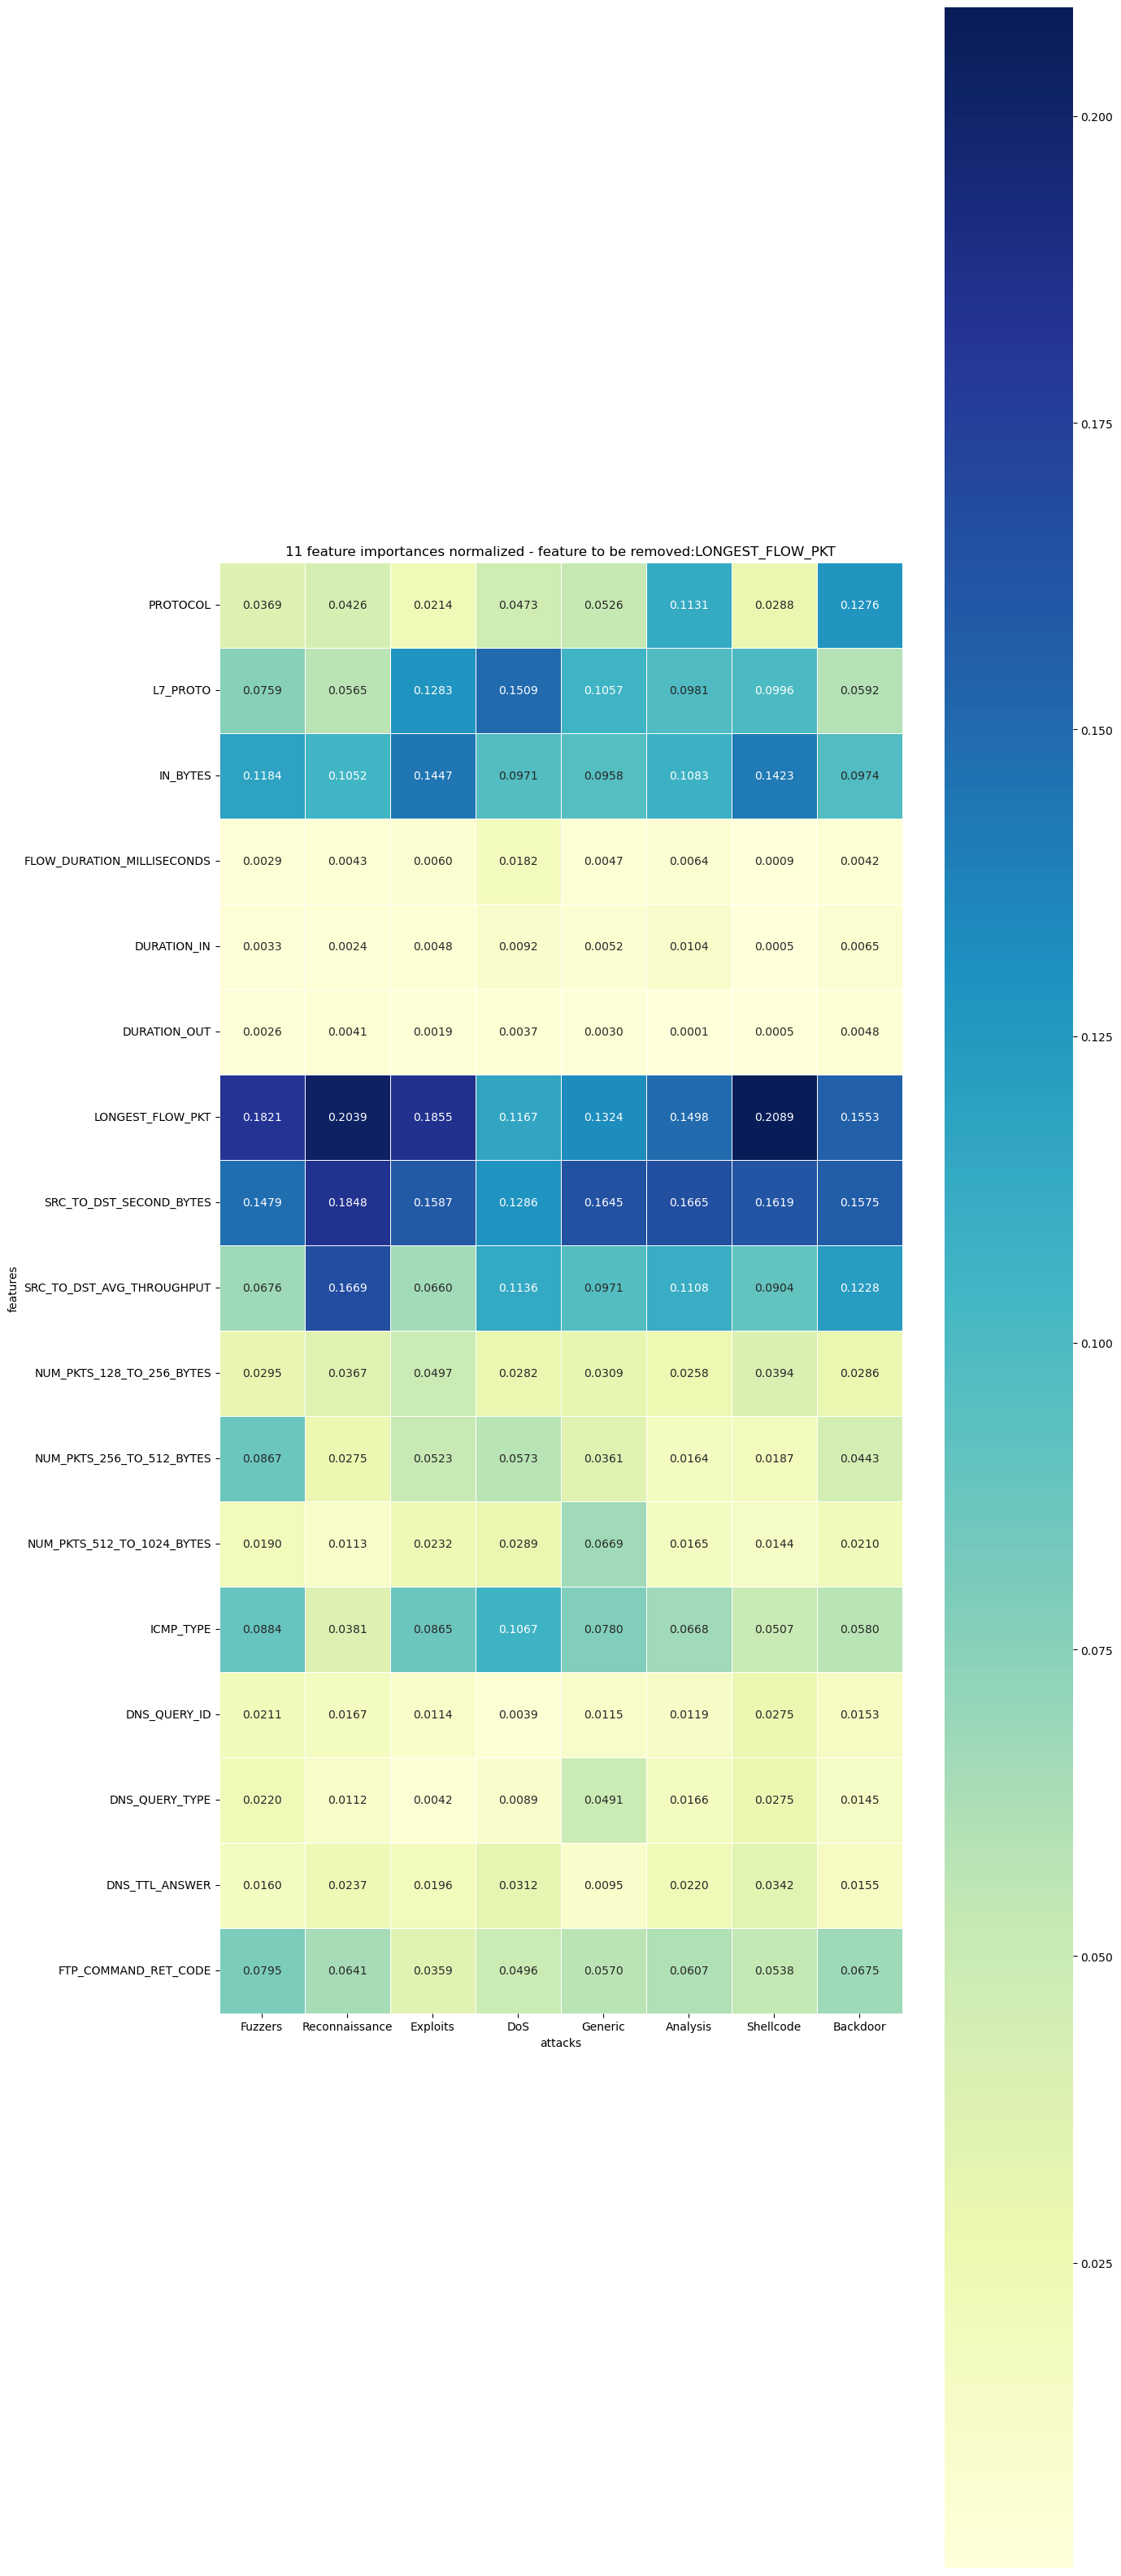

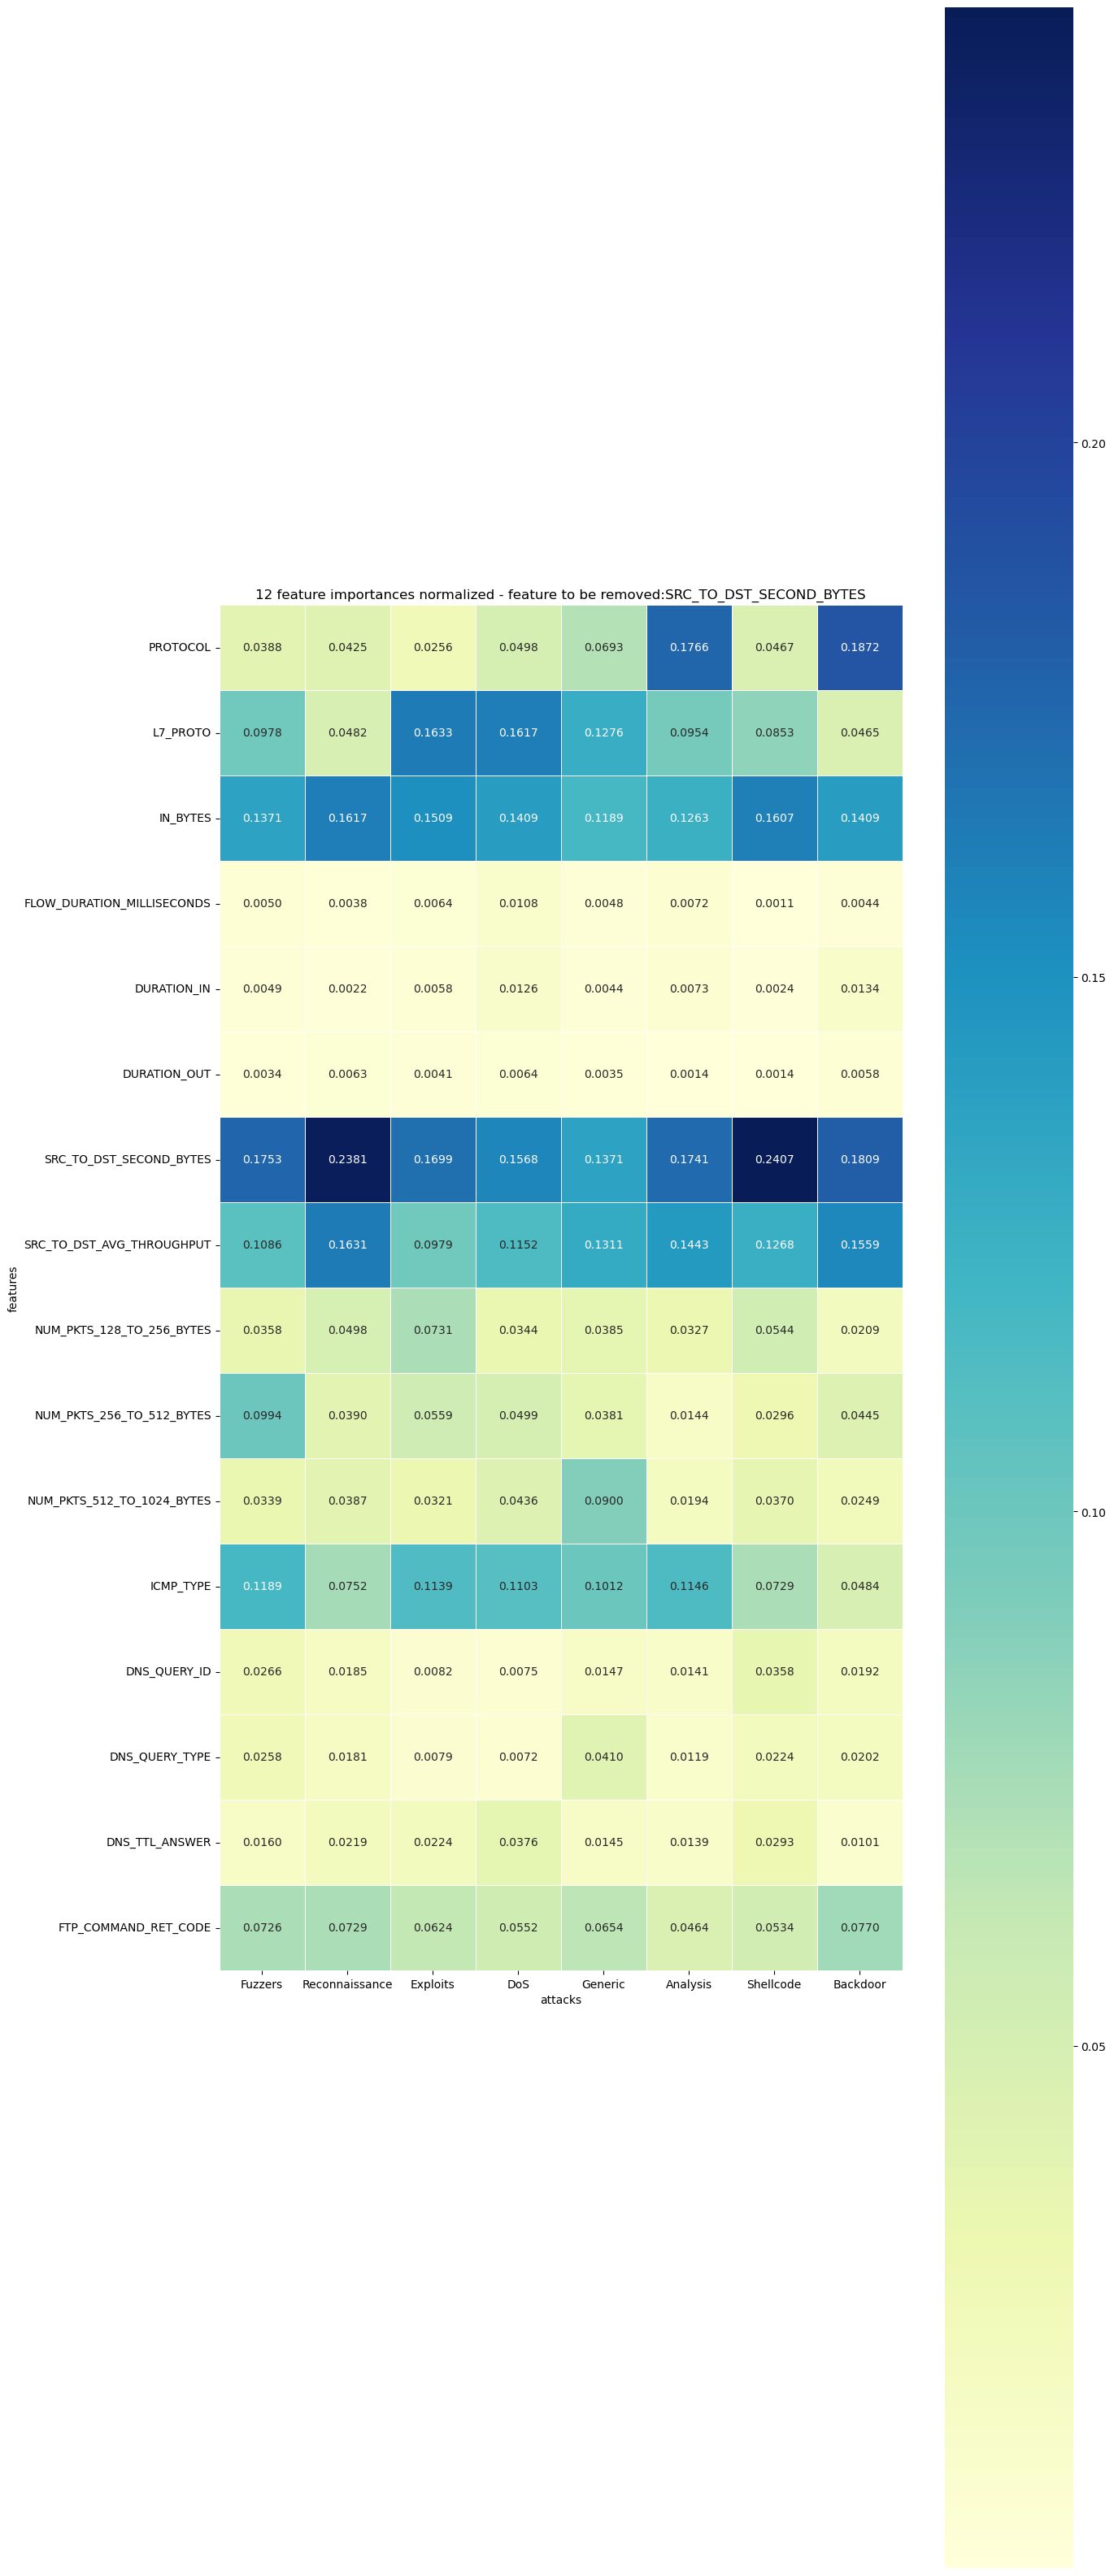

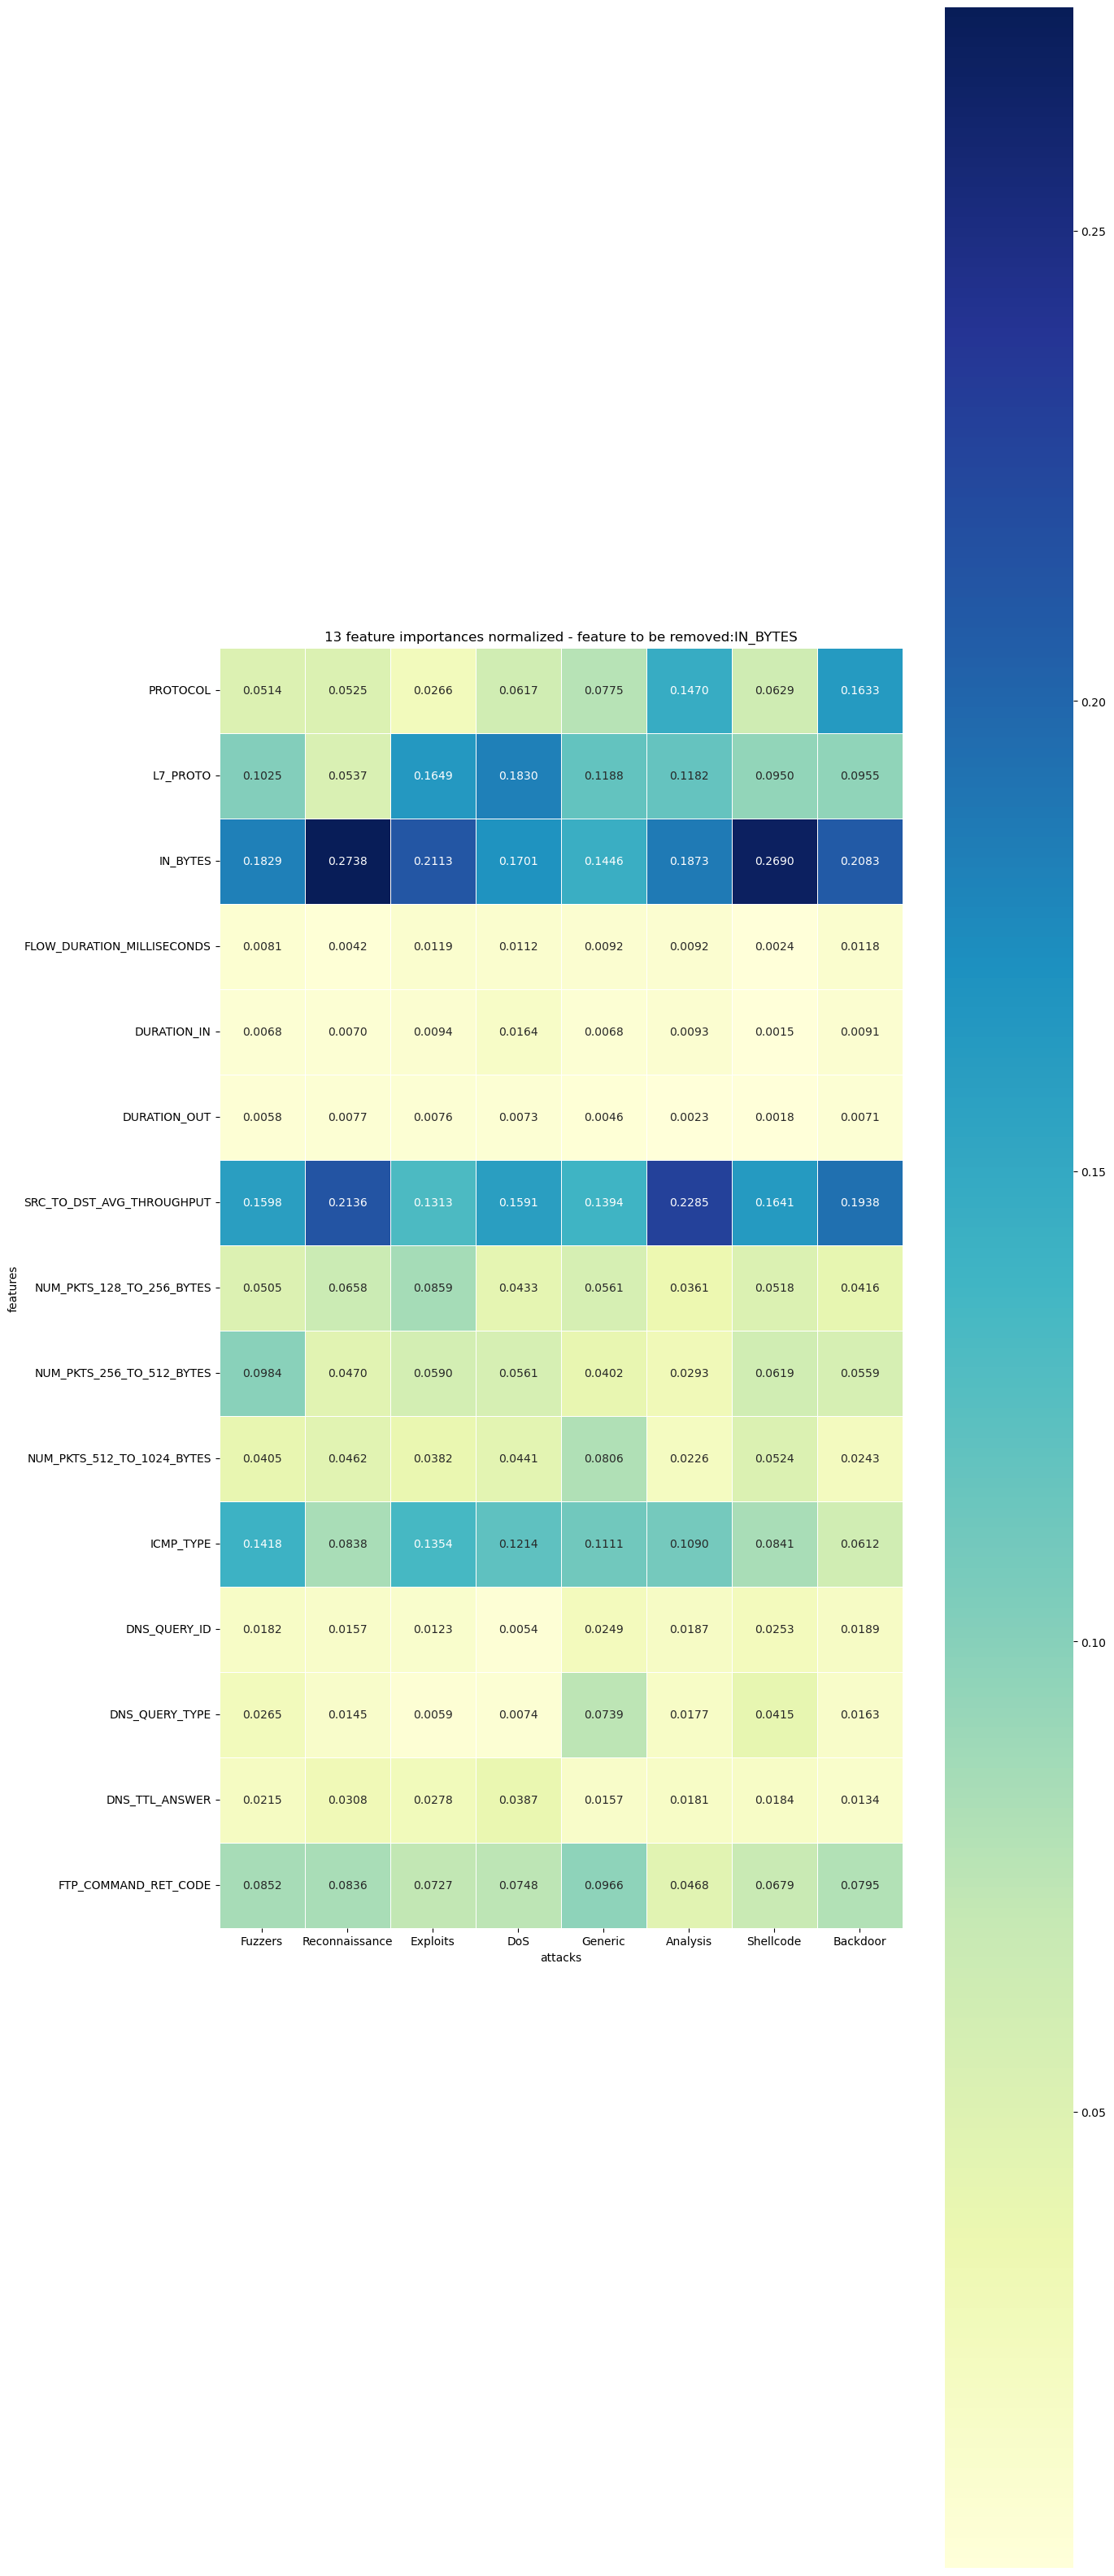

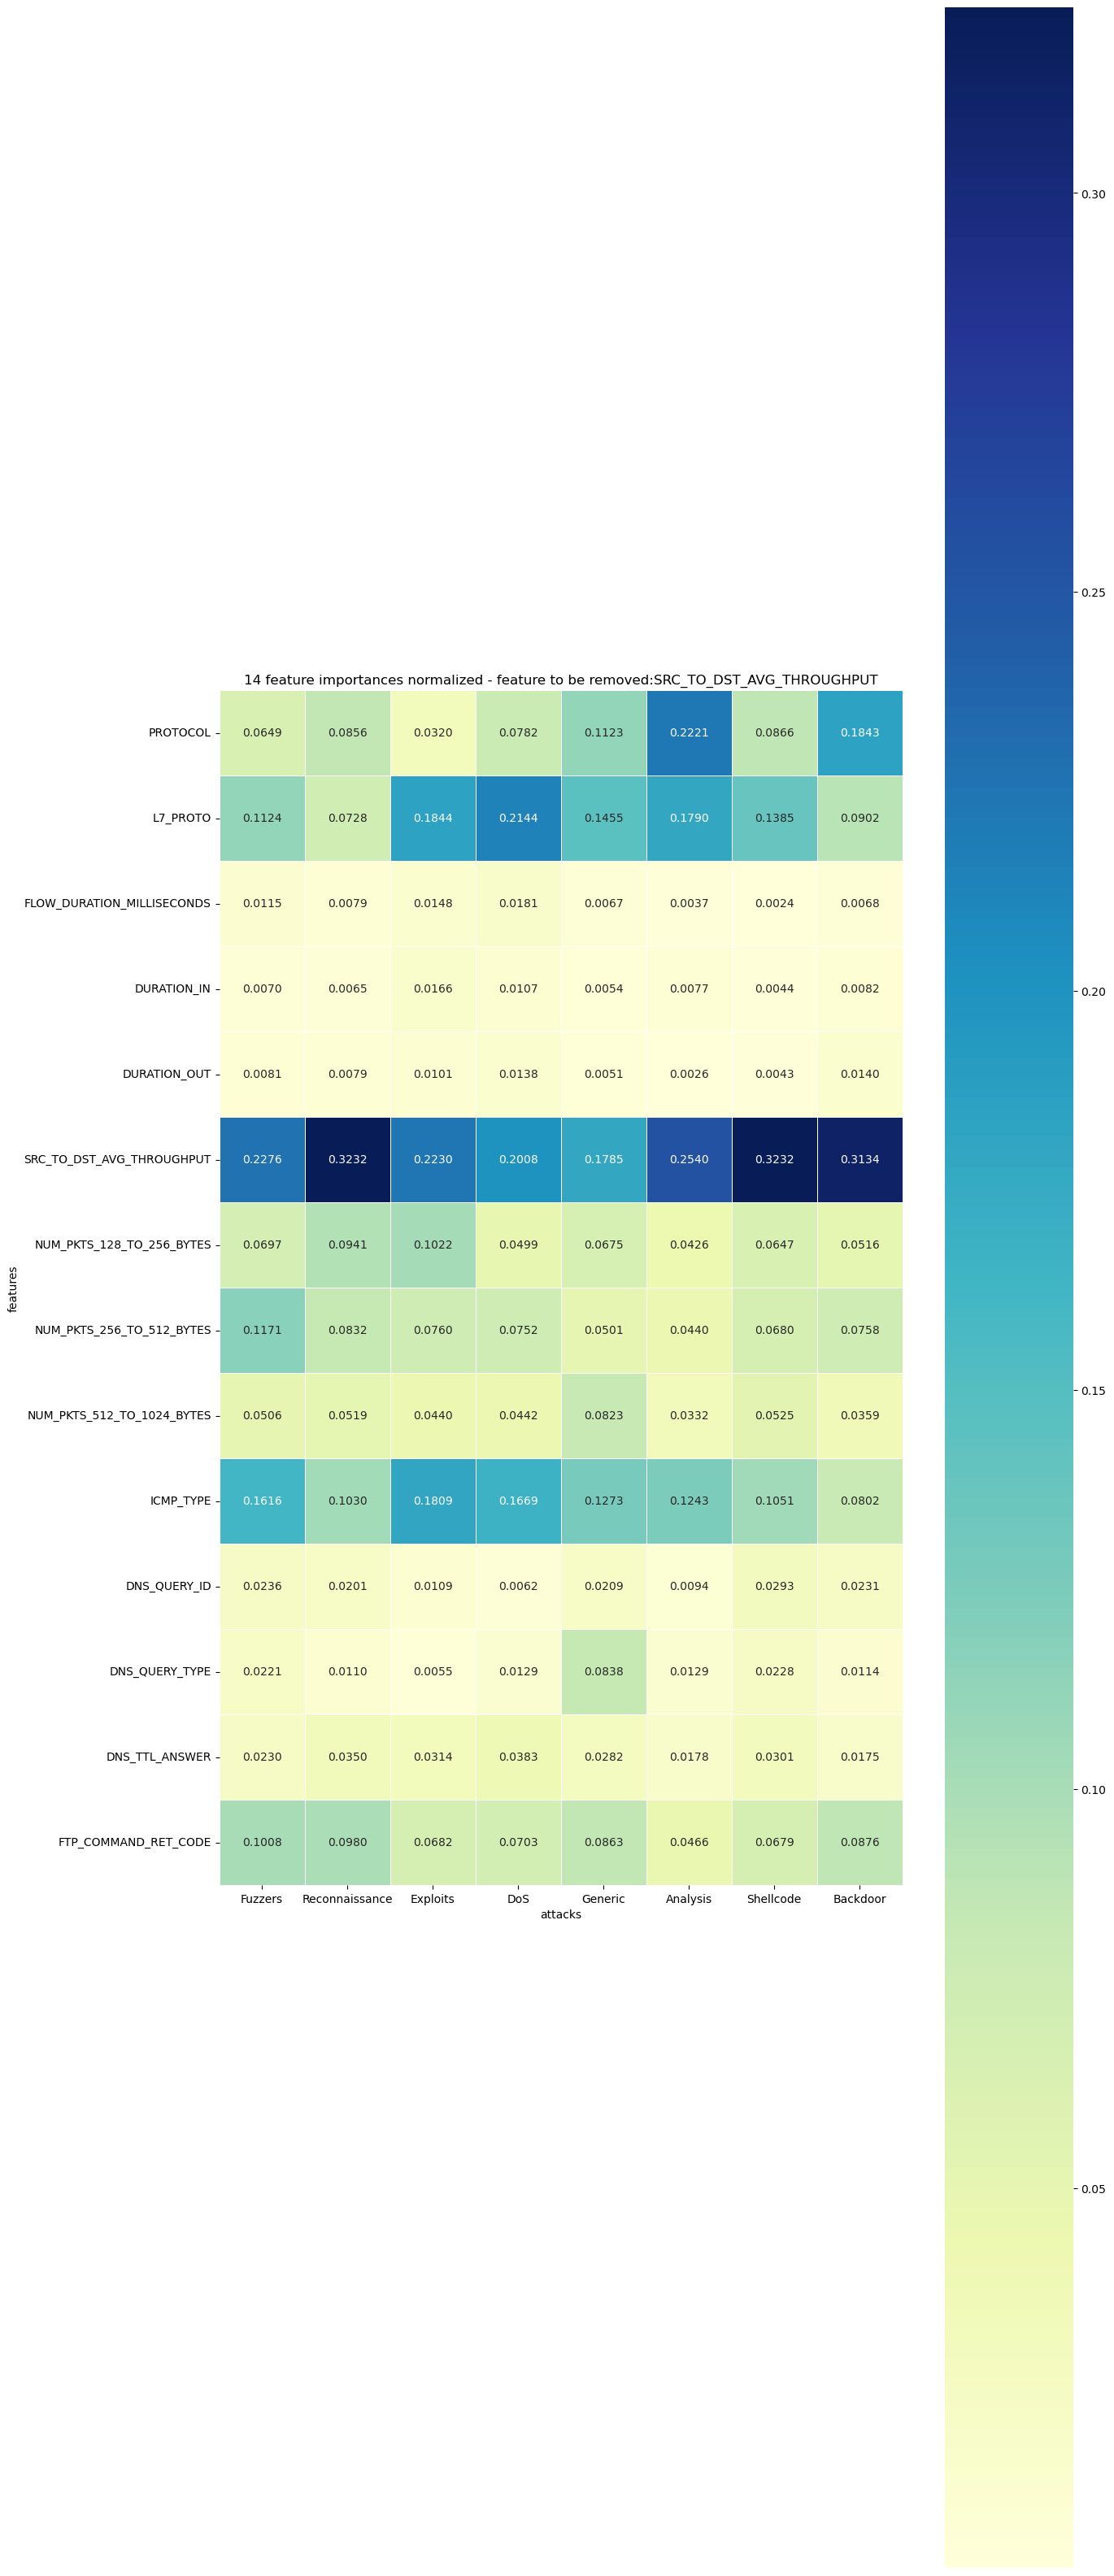

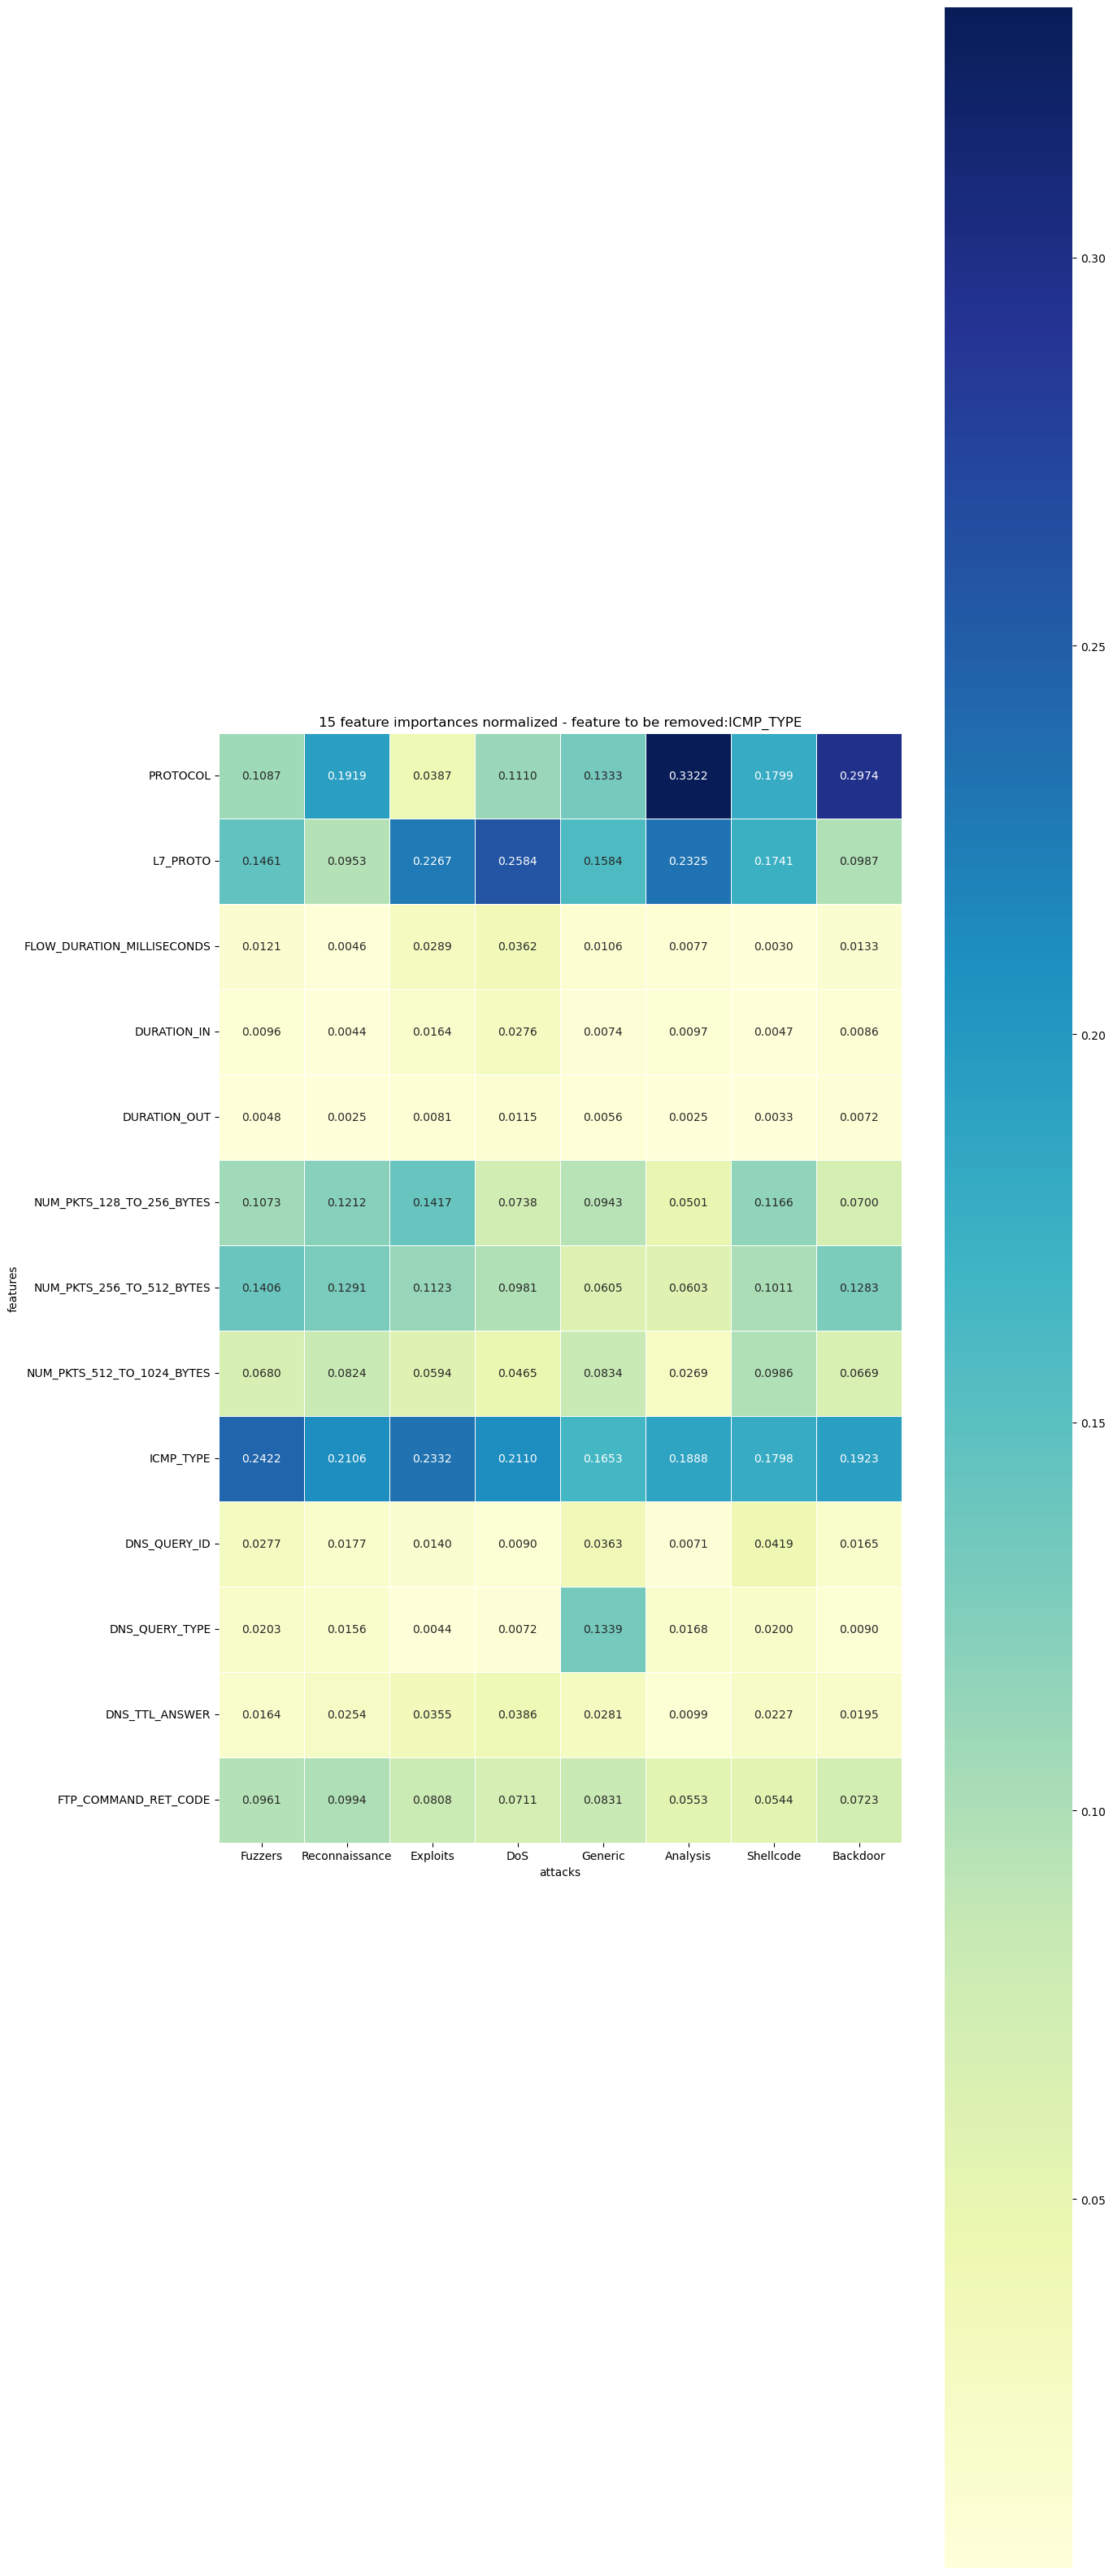

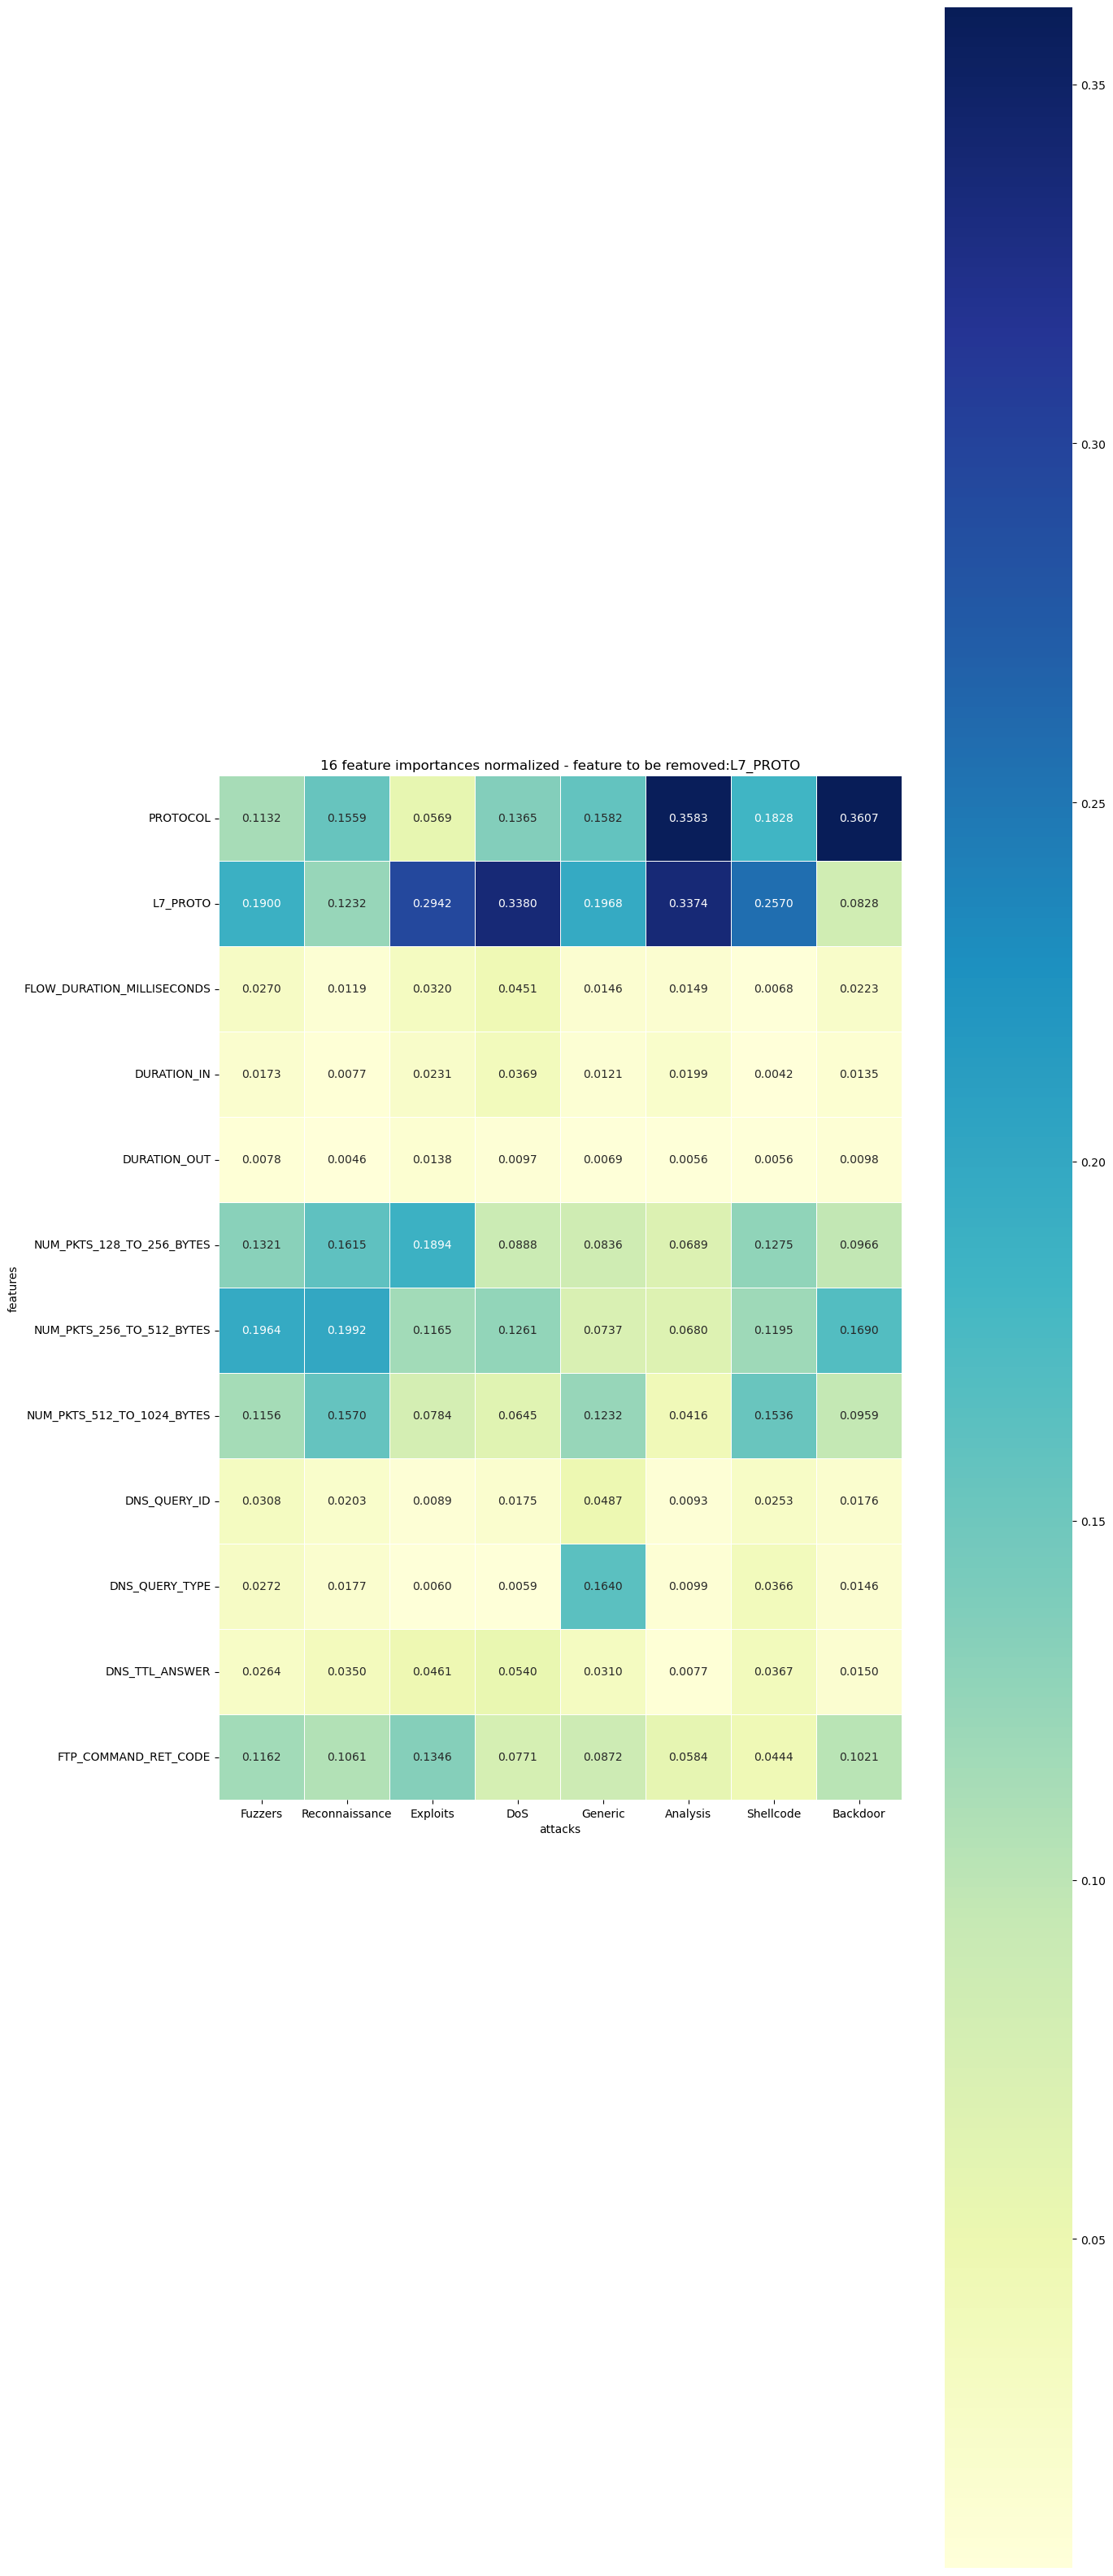

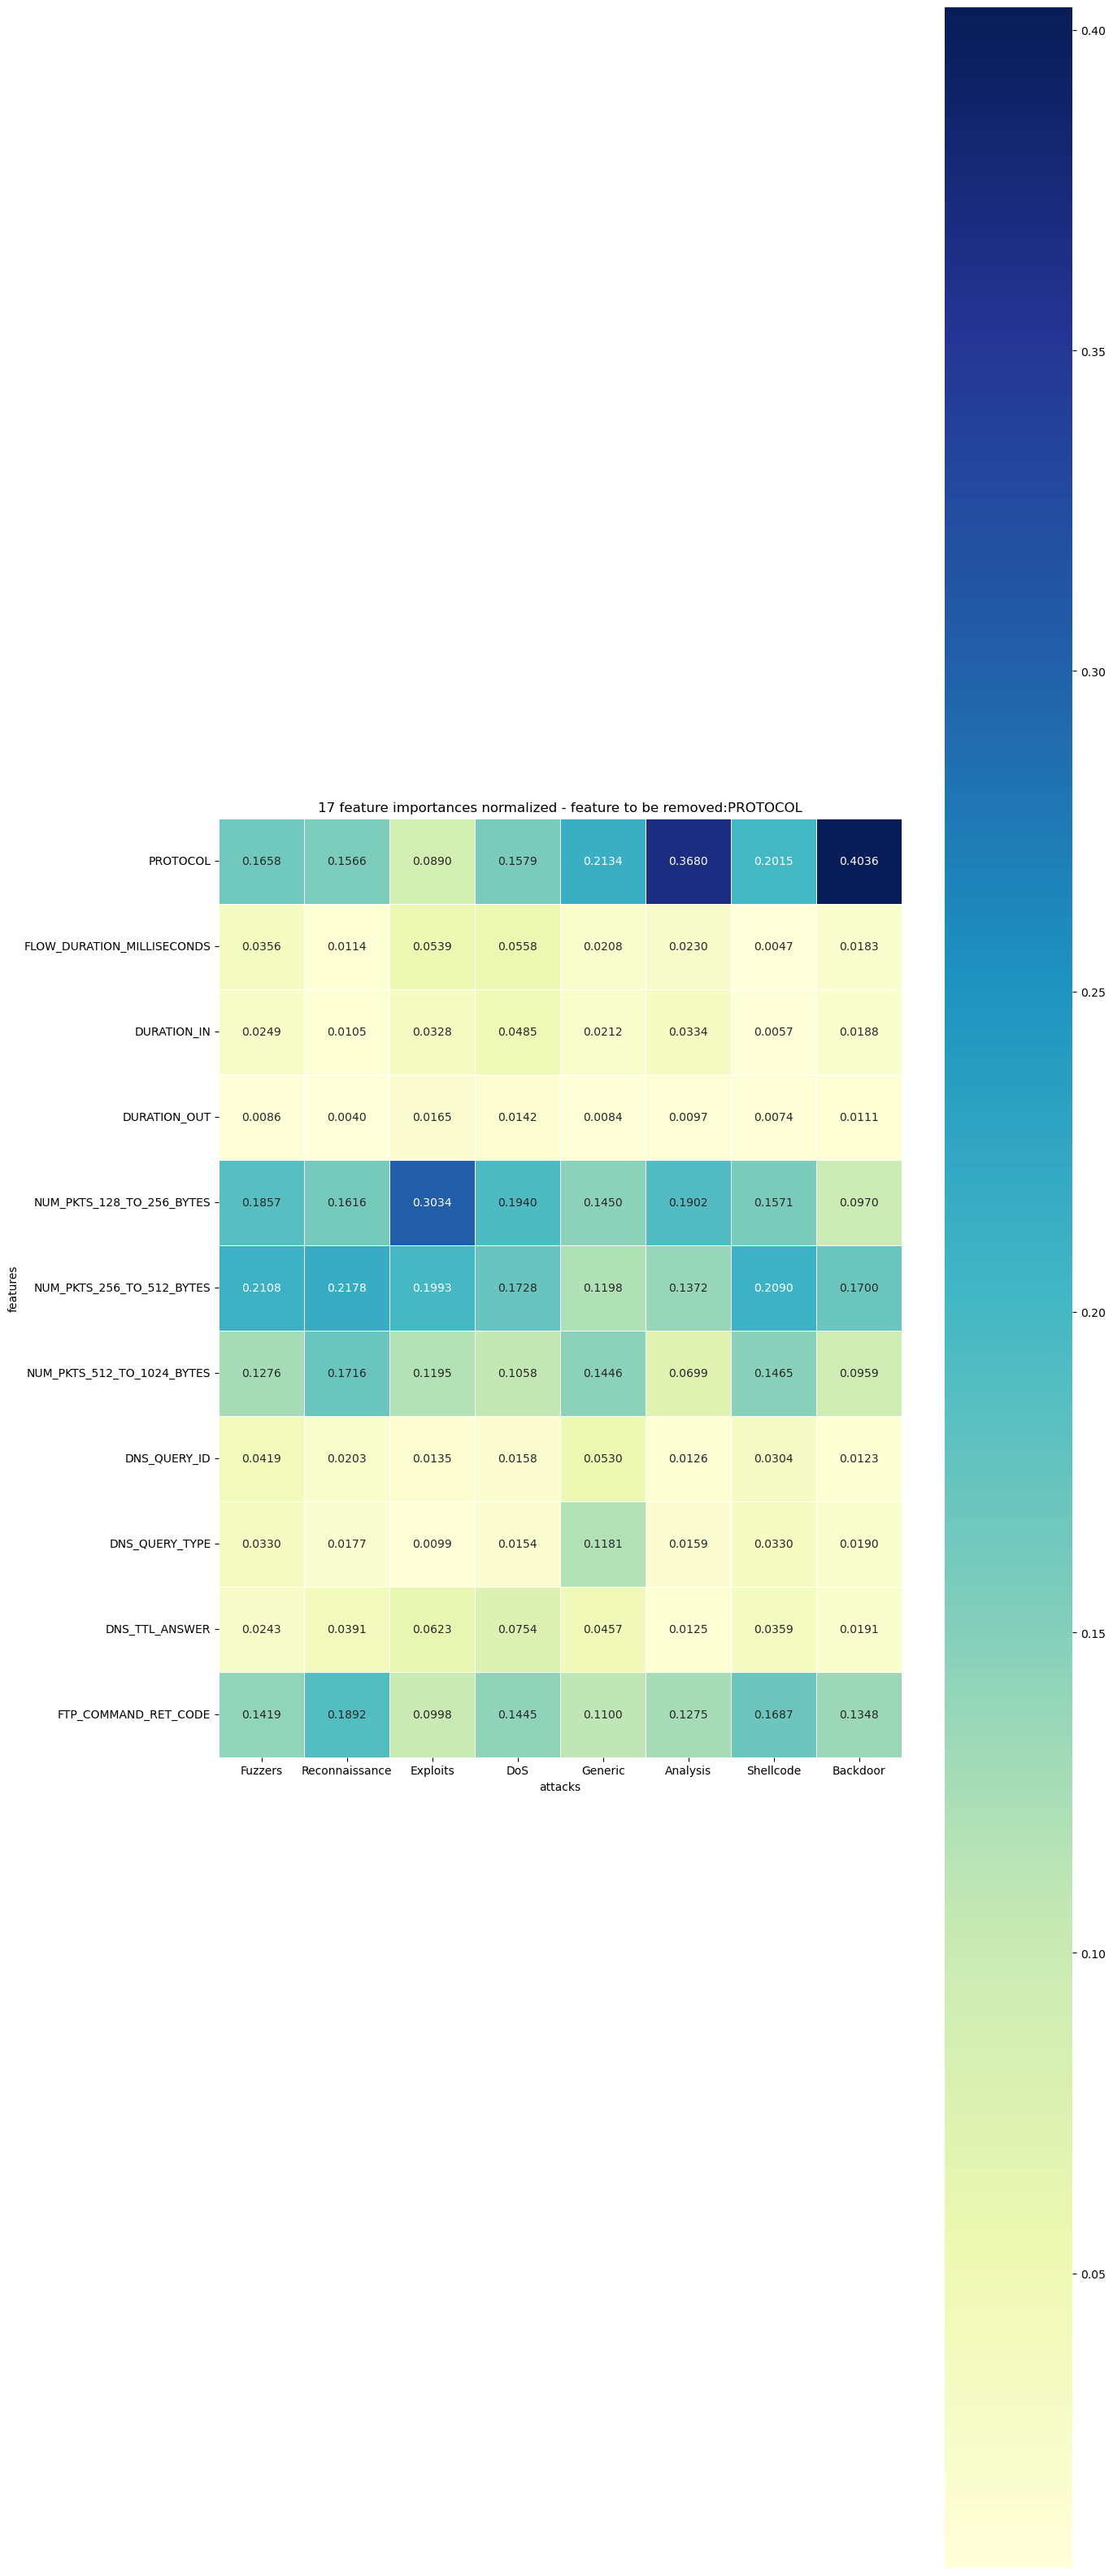

In [22]:

import matplotlib.pyplot as plt
import seaborn as sns

weight=0.5
iteration=0
possible_contaminants=[]
while True: #break when 1 of the models has a score lower than 0.8
    print(f"ITERATION: {iteration}")
#     -----------------Train Models-------------------------------
    prepared_result_rows = [] 
    for src_atk_type in attacks[1:]:
        dst_atk_type=src_atk_type
        accuracies = []
        precisions = []
        recalls = []
        importances=[]
        # zs = StandardScaler()
    #     oe=OrdinalEncoder()
        X_train = training_dfs[src_atk_type][training_dfs[src_atk_type].columns[:-1]]
    #     X_train[good_label_cols]=oe.fit_transform(X_train[good_label_cols])
        # X_train = zs.fit_transform(X_train.array.reshape(-1,1))
        y_train = training_dfs[src_atk_type][training_dfs[src_atk_type].columns[-1]]

        X_test = testing_dfs[dst_atk_type][testing_dfs[dst_atk_type].columns[:-1]]
    #     X_test[good_label_cols]=oe.transform(X_test[good_label_cols])

        # X_test = zs.transform(X_test.array.reshape(-1,1))
        y_test = testing_dfs[dst_atk_type][testing_dfs[dst_atk_type].columns[-1]]

        for i in range(6):
            clf=RandomForestClassifier()
            params = {
                                'bootstrap': True,
                                'max_features': 'sqrt',
                                'min_impurity_decrease': 0.0,
                                'min_samples_leaf': 2,
                                'n_estimators': 10,
                                'max_samples': 0.5,
                                'criterion': 'entropy',
                                'n_jobs': -1,
                                }
            clf.set_params(**params)
            clf.fit(X=X_train, y=y_train)

            outputs = clf.predict(X=X_test)
            explainer = shap.TreeExplainer(clf)
            shap_values = explainer.shap_values(X_test)

            importances.append(np.abs(shap_values[1]).mean(axis=0))
            accuracies.append(accuracy_score(y_true=y_test, y_pred=outputs))
            precisions.append(precision_score(y_true=y_test, y_pred=outputs, zero_division=0))
            recalls.append(recall_score(y_true=y_test, y_pred=outputs, zero_division=0))
        prepared_result_row = [
                        src_atk_type,
                        np.mean(importances,axis=0),
                        round(np.mean(accuracies), 3),
                        round(np.std(accuracies), 3),
                        round(np.mean(precisions), 3),
                        round(np.std(precisions), 3),
                        round(np.mean(recalls), 3),
                        round(np.std(recalls), 3),            
        ]
        print([prepared_result_row[0]]+prepared_result_row[2:])
        prepared_result_rows.append(prepared_result_row)
#   -----------------------Analyze Results -------------------------------
    #check if we can continue
    scores=[row[2] for row in prepared_result_rows]
    if any(x < 0.8 for x in scores):
        break

    #normalize importances
    stacked_array_norm = np.stack([row[1]/row[1].sum() for row in prepared_result_rows], axis=1)
    
    #average over all attack classes
    importances=stacked_array_norm.mean(axis=1)
    
    variance=stacked_array_norm.var(axis=1)
    #get the most important (weighted by variance) feature
    weighted_importances=(1-weight)*importances+(weight)*(0.25-variance)
    sorted_indices = np.argsort(weighted_importances)[::-1]
    sorted_labels = [X_test.columns[i] for i in sorted_indices]
    sorted_importances = importances[sorted_indices]
    print(f"top features {sorted_labels[:3]}")
    print(f"top importances {sorted_importances[:3]}")
    print(f" feature to be dropped: {sorted_labels[0]}")
    print(f" correlated features: {[feature_group for feature_group in corr_list if sorted_labels[0] in feature_group]}")
    possible_contaminants.append(sorted_labels[0])
    possible_contaminants+=[feature_group for feature_group in corr_list if sorted_labels[0] in feature_group]
    #create figure
    fig, ax = plt.subplots(figsize=(15, 50))

    # create heatmap with annotations
    sns.heatmap(stacked_array_norm, annot=True, fmt='.4f', cmap='YlGnBu', cbar=True, square=True, linewidths=.5, ax=ax)

    # set title and labels
    ax.set_title(f"{iteration} feature importances normalized - feature to be removed:{sorted_labels[0]}")
    ax.set_xlabel('attacks')
    ax.set_ylabel('features')

    # set x and y ticklabels to categorical labels
    ax.set_xticklabels(attacks[1:])
    ax.set_yticklabels(X_train.columns, rotation=0, ha='right')
    plt.subplots_adjust(left=0.2)
    plt.savefig(f"{iteration}_heatmap_{sorted_labels[0]}.png")

    #remove the feature
    for key,value in training_dfs.items():
        value.drop(columns=[sorted_labels[0]],inplace=True)

    for key,value in testing_dfs.items():
        value.drop(columns=[sorted_labels[0]],inplace=True)
    iteration+=1